# Data Analysis on V5 API

## Research questions:

1. What's the number of challenges by status over different granularity (e.g. year, month, week)?
  - Specifically, what does the cancelled challenges' distribution looked like?
2. There are 4 tracks now, a new **"QA"** track is added. What's the mapping from legacy track/sub-track to new track?
3. There are 3 types of challenge now, **"first to finish"** and **"task"** are separated from **"challenge"**, where do these two new challenges come from (legacy track/sub track)?
4. * Looking at the prize set of the challenges, what's the distrobution in different track/legacy track?

In [1]:
%matplotlib inline
import os
import re
import pathlib
from pprint import pprint
from collections import defaultdict
from datetime import datetime

import pymongo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors

import topcoder_mongo as DB
import static_var as S
import util as U

sns.set(
    rc={
        'axes.facecolor':'#121212',
        'figure.facecolor':'#121212',
        'text.color': 'white',
        'axes.titlecolor': 'white',
        'axes.labelcolor': 'white',
        'xtick.color': 'white',
        'ytick.color': 'white',
        'figure.autolayout': True,
    },
)

pd.set_option('display.max_rows', 500)

In [2]:
PATH = pathlib.Path('.').resolve().parent.parent / 'presentation' / 'presentation6'
SAVEFIG = False # Global var that control figure saving
TRANSPARENT = False

## Plots and analysis

> To reduce the length of variable, abbrevations of words are used.
> Usually when you see `cha_*` it means `challenges_*`.

### Number of Challenges by time range.

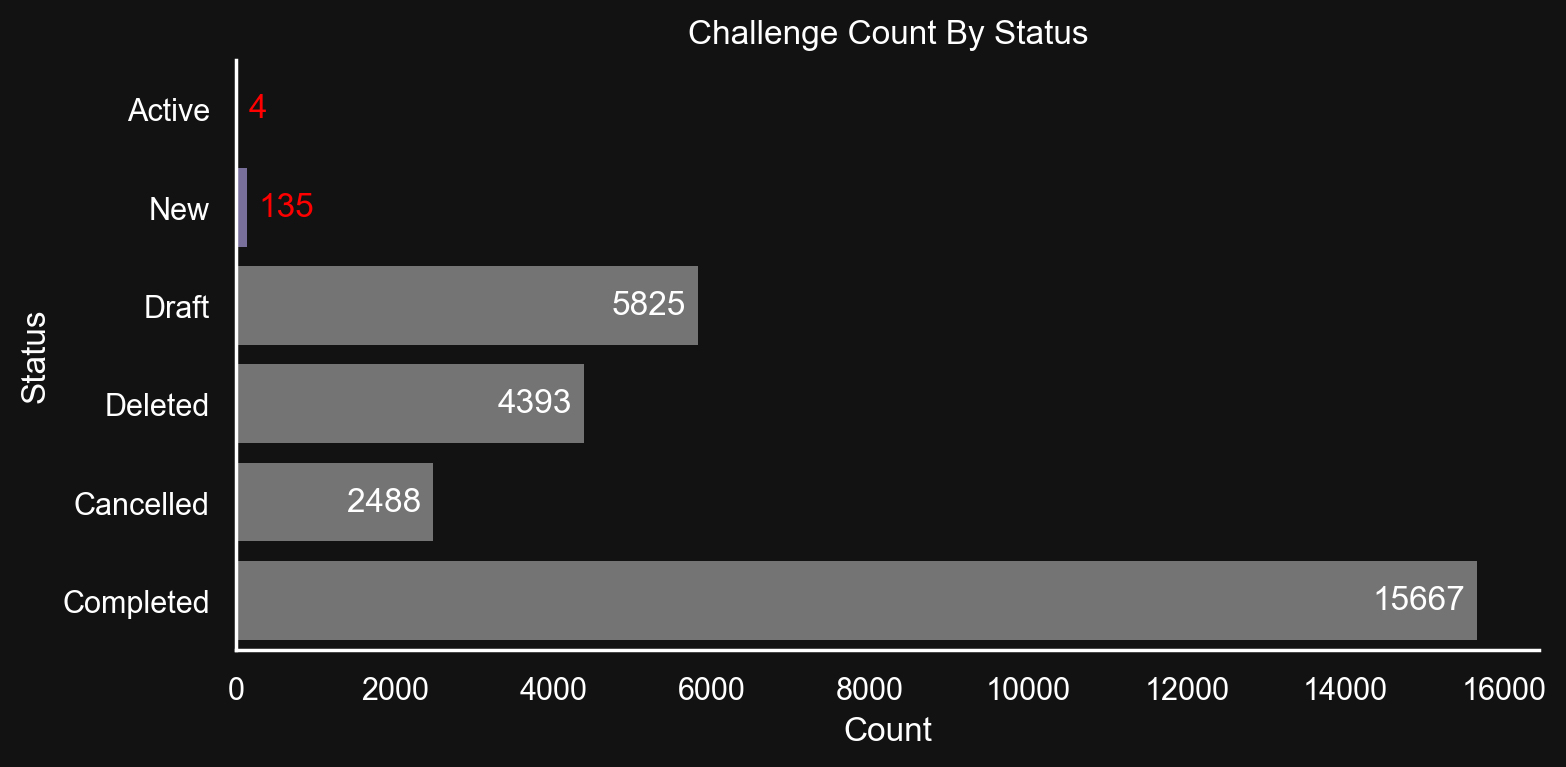

In [3]:
query = [
    {'$match': {'end_date': {'$lte': U.year_end(2020)}}},
    {
        '$project': {
            'status': {'$arrayElemAt': [{'$split': ['$status', ' - ']}, 0]},
            'end_date': '$end_date',
        },
    },
    {'$group': {'_id': {'status': '$status'}, 'count': {'$sum': 1}}},
    {'$replaceRoot': {'newRoot': {'$mergeObjects': ['$_id', {'count': '$count'}]}}},
]

cha_cnt_status_df = pd.DataFrame.from_records(
    data=DB.TopcoderMongo.run_challenge_aggregation(query),
)

fig, ax = plt.subplots(1, 1, figsize=(8, 4), dpi=200)

sns.despine()
sns.barplot(
    data=cha_cnt_status_df,
    x='count',
    y='status',
    order=S.STATUS[::-1],
    linewidth=0,
    alpha=0.9,
    palette=['#937860', '#8172B3'] + ['grey'] * 4,
    ax=ax,
)

ax.grid(False)
ax.set_title('Challenge Count By Status')
ax.set_xlabel('Count')
ax.set_ylabel('Status')

for p in ax.patches:
    cnt = int(p.get_width())
    x = p.get_width()
    y = p.get_height() / 2 + p.get_y()
    ax.annotate(
        cnt,
        xy=(x, y),
        xytext=(x + 150 if cnt < 140 else x - 150, y),
        va='center',
        ha= 'left' if cnt < 140 else 'right',
        color='red' if cnt < 140 else 'white'
    )
    
if SAVEFIG:
    fig.savefig(PATH / 'status_count.png', dpi='figure', transparent=TRANSPARENT)

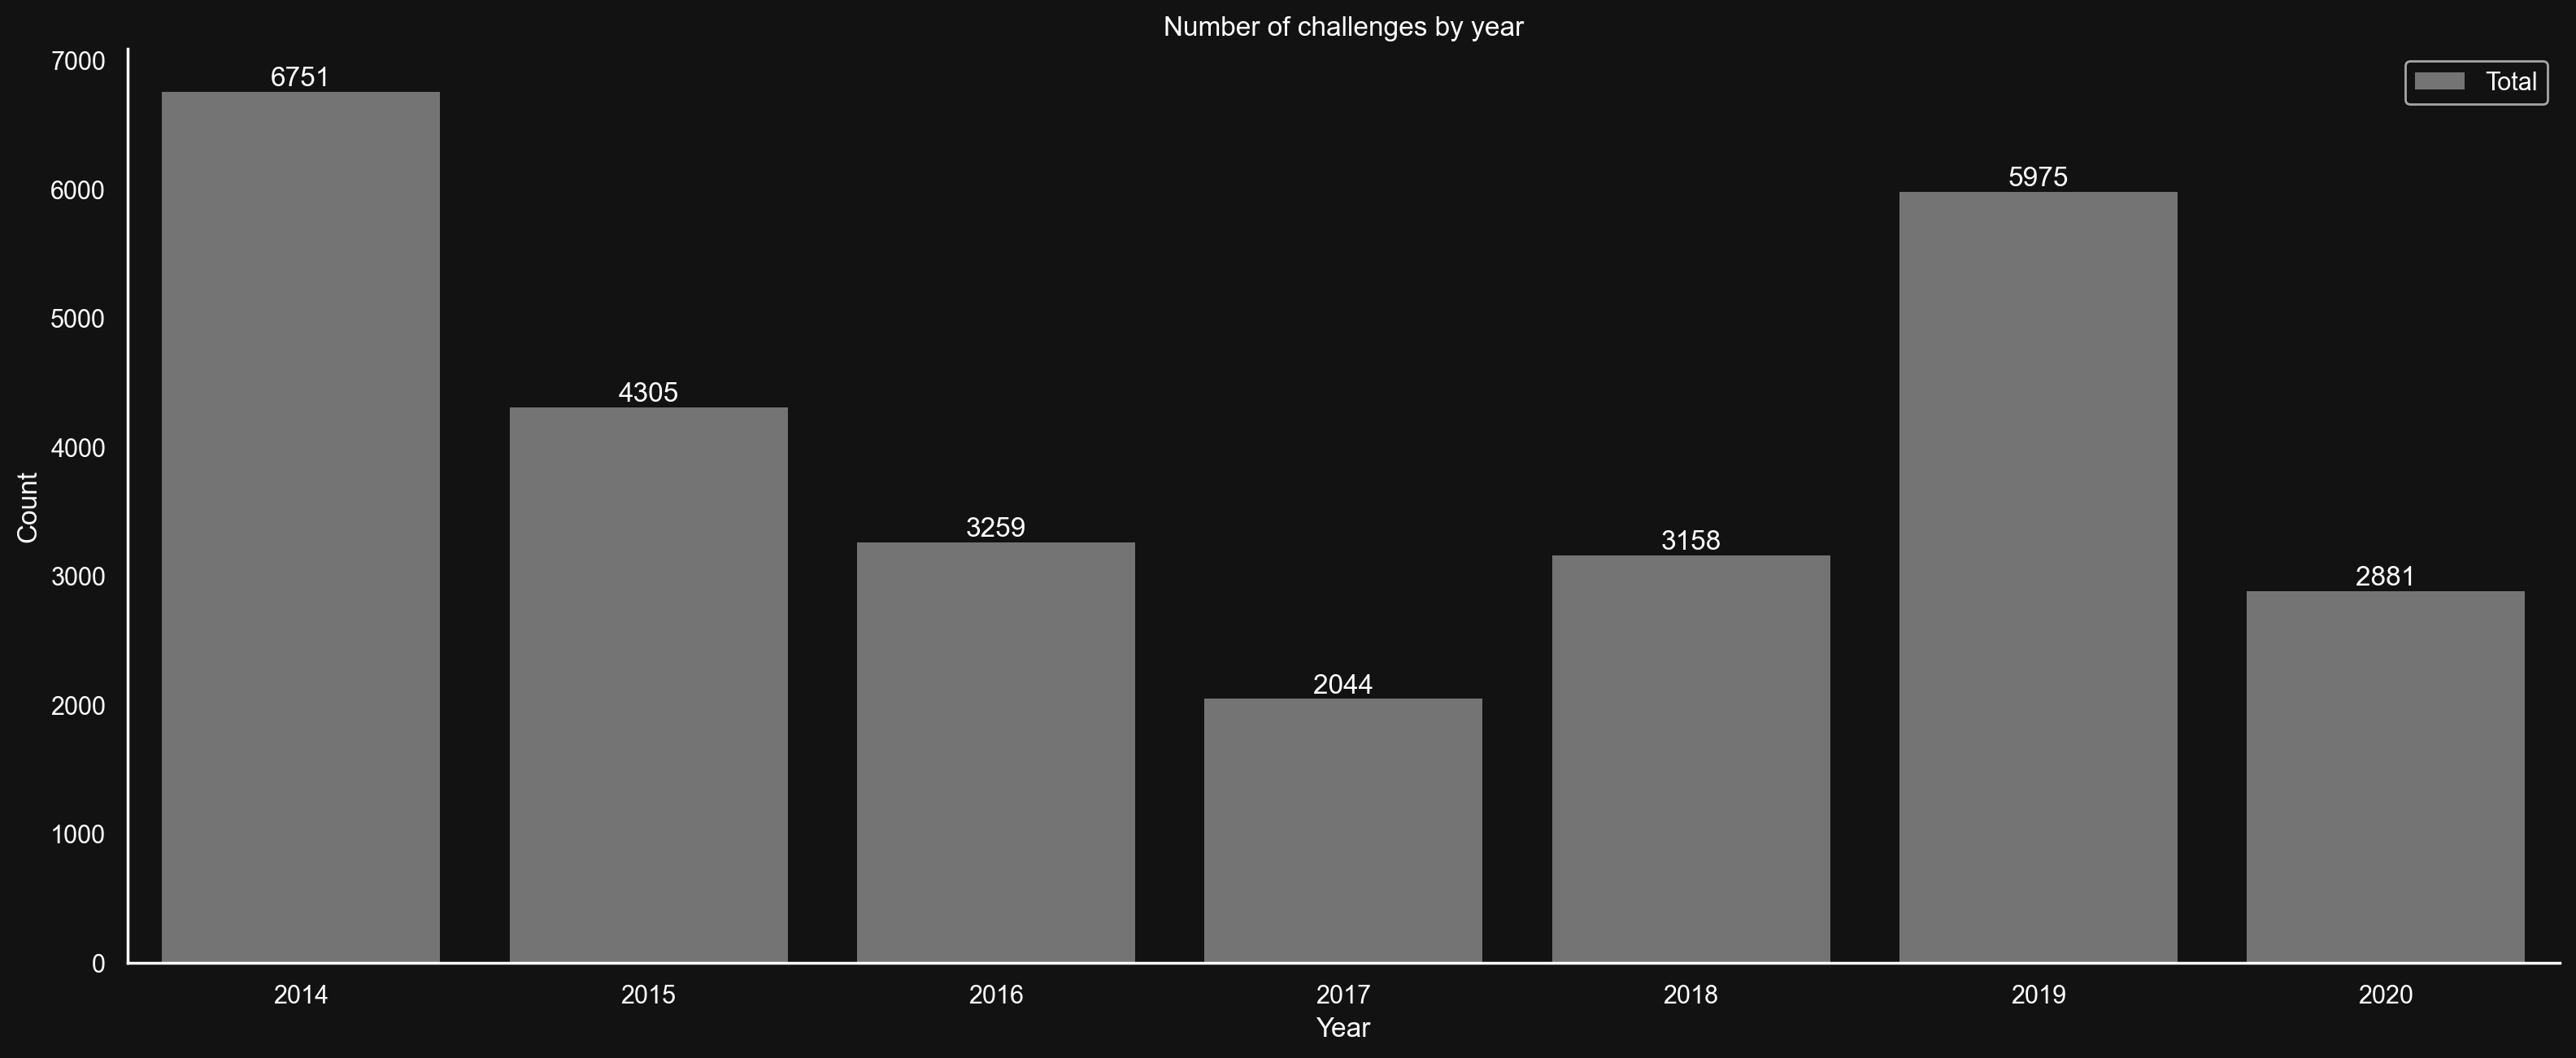

In [4]:
cha_cnt_year_df = pd.DataFrame.from_records(
    data=DB.TopcoderMongo.get_challenge_count('year', '%Y', S.STATUS[:-2]),
).set_index(['year', 'status']).sort_index()

fig, ax = plt.subplots(1, 1, figsize=(16, 6.67), dpi=200)
sns.despine()

data = (cha_cnt_year_df
        .groupby('year')
        .sum()\
        .reset_index()
        .apply({'year': lambda dt: dt.strftime('%Y'), 'count': lambda cnt: cnt}))

sns.barplot(
    data=data,
    x='year',
    y='count',
    linewidth=0,
    color='grey',
    alpha=0.9,
    label='Total',
    ax=ax,
)

ax.grid(False)
ax.set_title('Number of challenges by year')
ax.set_xlabel('Year')
ax.set_ylabel('Count')
ax.legend()

# set the width of bar to be connected to each other
for p in ax.patches:
#     p.set_width(1)
#     p.set_x(p.get_x() - 0.1)
    
    cnt = p.get_height()
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(int(cnt), xy=(x, y), xytext=(x, y + 50), ha='center')

# fig.autofmt_xdate()
if SAVEFIG:
    fig.savefig(PATH / 'num_of_challenge_year.png', dpi='figure', transparent=TRANSPARENT)

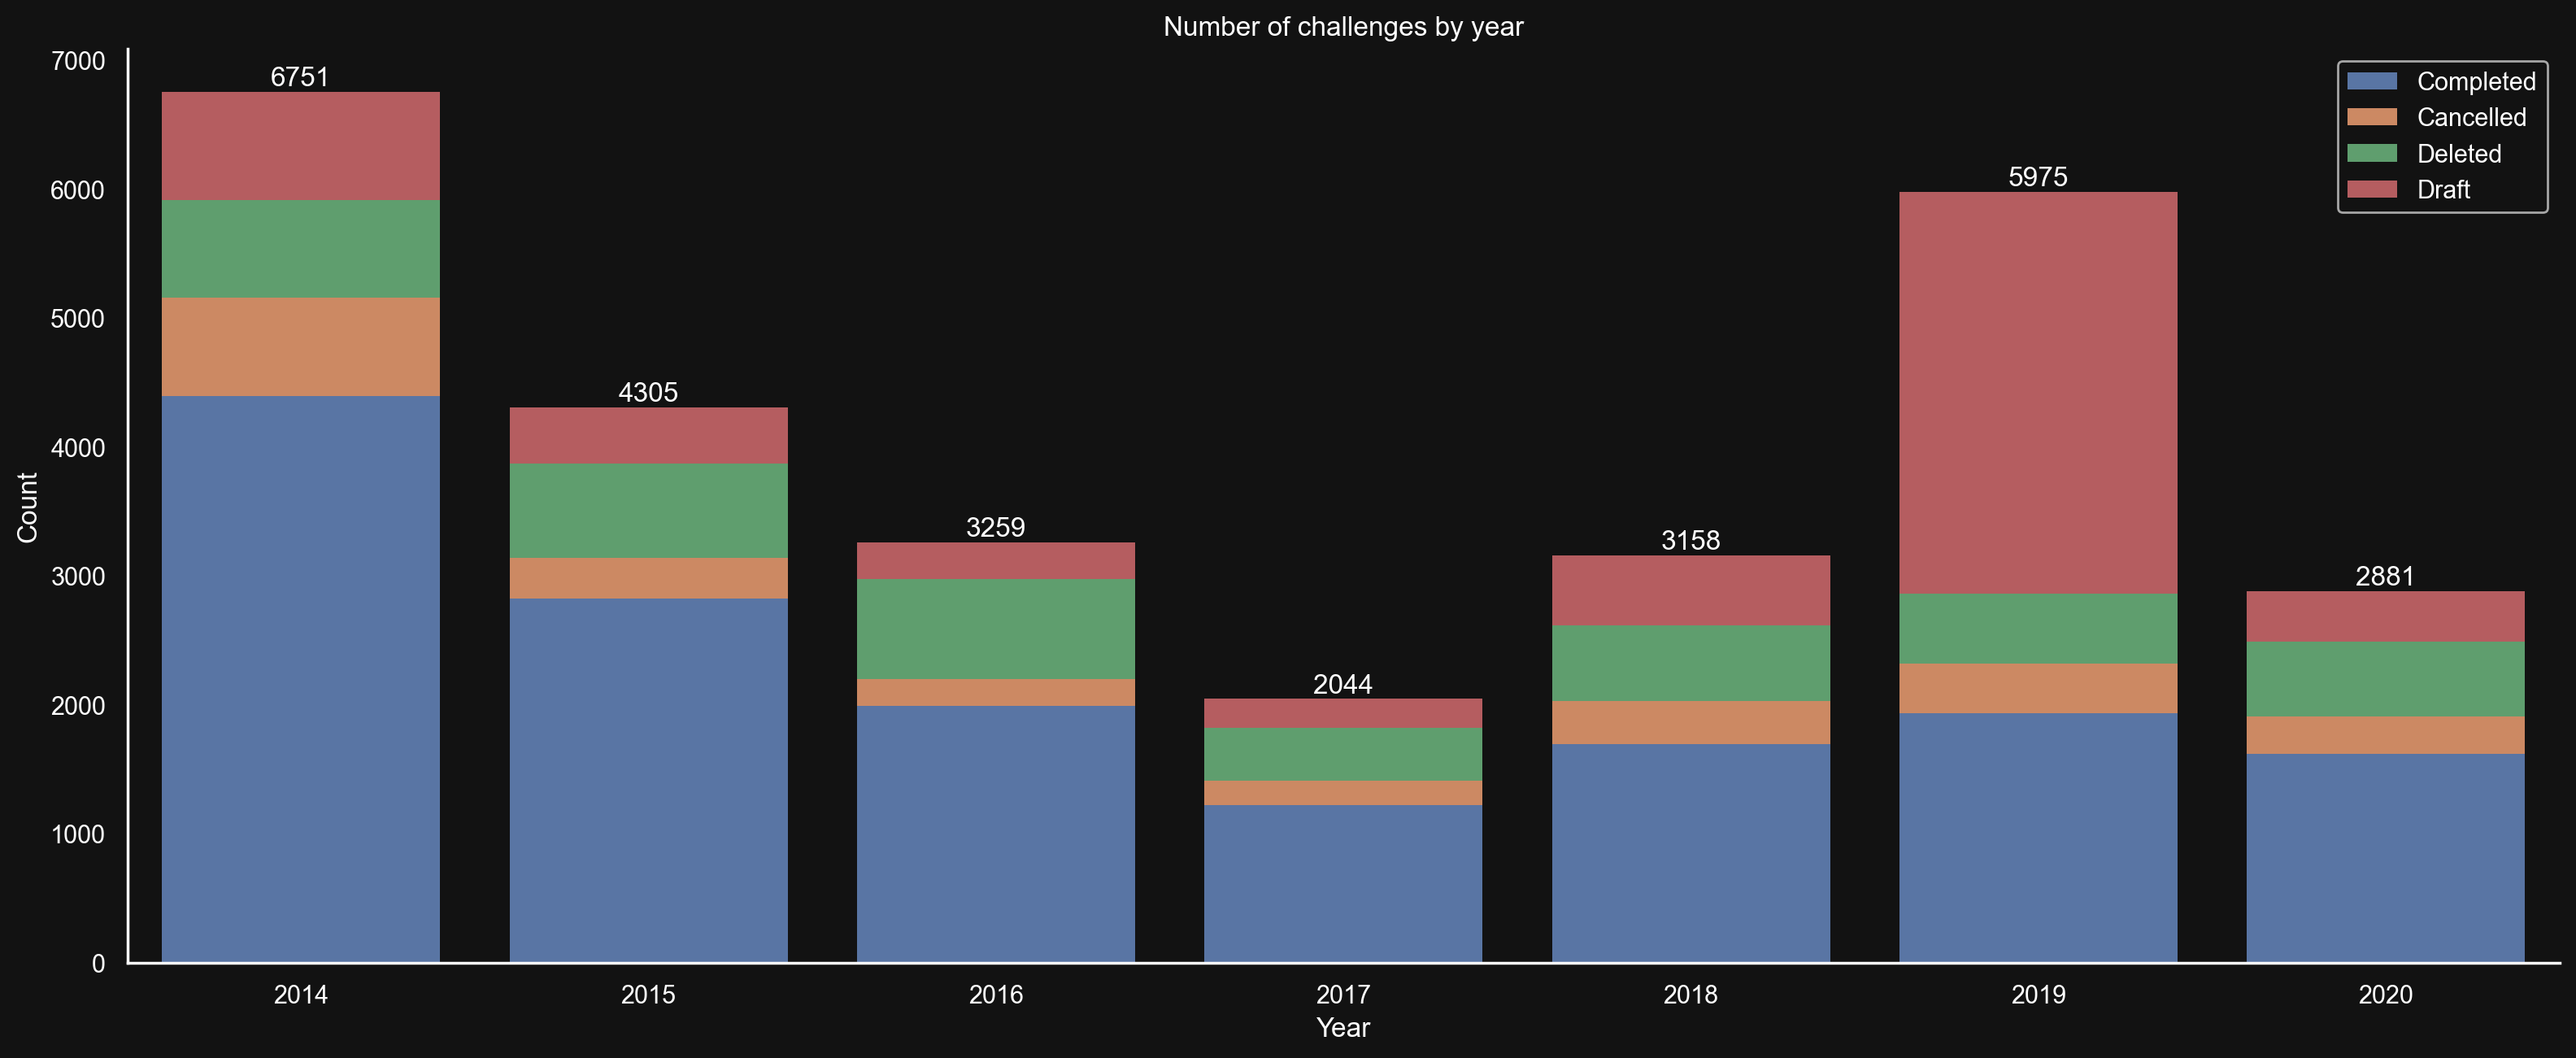

In [5]:
color_palette = list(sns.color_palette(n_colors=4).as_hex())
fig, ax = plt.subplots(1, 1, figsize=(16, 6.67), dpi=200)
sns.despine()

challenge_count_by_year = defaultdict(dict)
for idx, status in enumerate(S.STATUS[:-2]):
    challenge_count_by_year[status]['data'] = cha_cnt_year_df.loc[(slice(None), status), :].reset_index('status', drop=True)
    challenge_count_by_year[status]['color'] = color_palette[idx]
    if idx == 0:
        challenge_count_by_year[status]['bottom'] = pd.DataFrame({'count': [0] * 7}, index=cha_cnt_year_df.index.get_level_values('year').unique())
        
    else:
        challenge_count_by_year[status]['bottom'] = cha_cnt_year_df.loc[(slice(None), S.STATUS[:idx]), :].groupby('year').sum()

for status, data_dct in challenge_count_by_year.items():
    sns.barplot(
        x=data_dct['data'].index.strftime('%Y'),
        y=data_dct['data']['count'],
        bottom=data_dct['bottom']['count'],
        color=data_dct['color'],
        linewidth=0,
        label=status,
        ax=ax,
    )
    
# ax.set_xticklabels(cha_cnt_year_df.index.get_level_values('year').unique().strftime('%Y'))
ax.grid(False)
ax.set_title('Number of challenges by year')
ax.set_xlabel('Year')
ax.set_ylabel('Count')
ax.legend()

text_coords = defaultdict(int)
for p in ax.patches:
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    text_coords[x] += y
    
for x, y in text_coords.items():
    cnt = int(y)
    ax.annotate(cnt, xy=(x, y), xytext=(x, y + 50), ha='center')
    
if SAVEFIG:
    fig.savefig(PATH / 'num_of_challenge_year_hue_all.png', dpi='figure', transparent=TRANSPARENT)

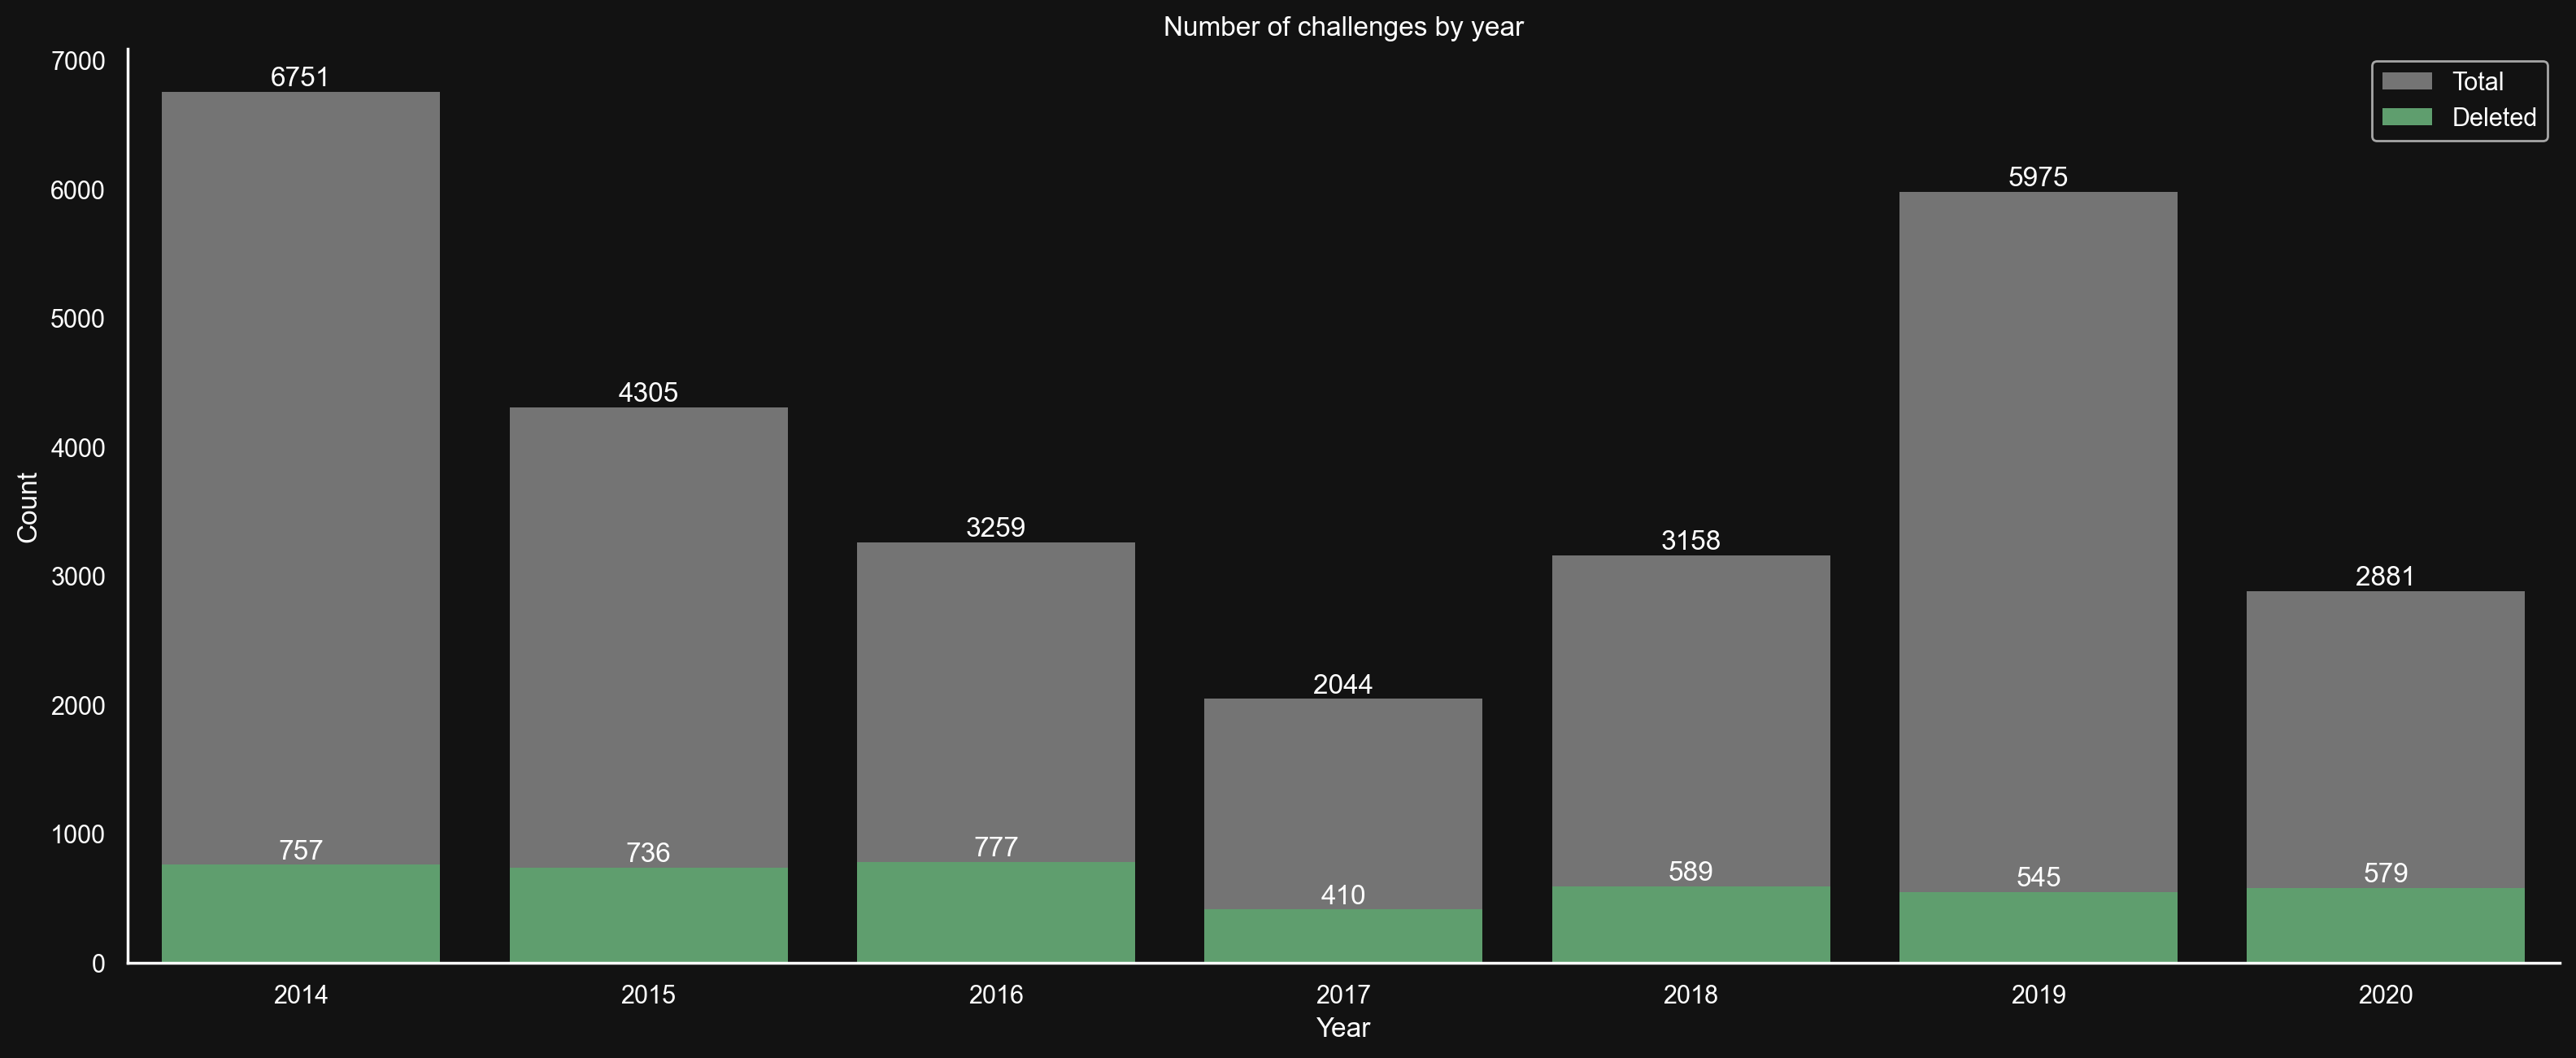

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(16, 6.67), dpi=200)
sns.despine()

status = 'Deleted'
status_data = challenge_count_by_year[status]

sns.barplot(
    data=data,
    x='year',
    y='count',
    color='grey',
    linewidth=0,
    alpha=0.9,
    label='Total',
    ax=ax,
)

sns.barplot(
    x=status_data['data'].index.strftime('%Y'),
    y=status_data['data']['count'],
    color=status_data['color'],
    linewidth=0,
    label=status,
    ax=ax,
)

ax.grid(False)
ax.set_title('Number of challenges by year')
ax.set_xlabel('Year')
ax.set_ylabel('Count')
ax.legend()

text_coords = defaultdict(list)
for p in ax.patches:
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    text_coords[x].append(y)
    
for x, ys in text_coords.items():
    y_part, y_all = sorted(ys)
    ax.annotate(int(y_part), xy=(x, y_part), xytext=(x, y_part + 50), ha='center')
    ax.annotate(int(y_all), xy=(x, y_all), xytext=(x, y_all + 50), ha='center')

if SAVEFIG:
    fig.savefig(PATH / f'num_of_challenge_year_hue_{status}.png', dpi='figure', transparent=TRANSPARENT)

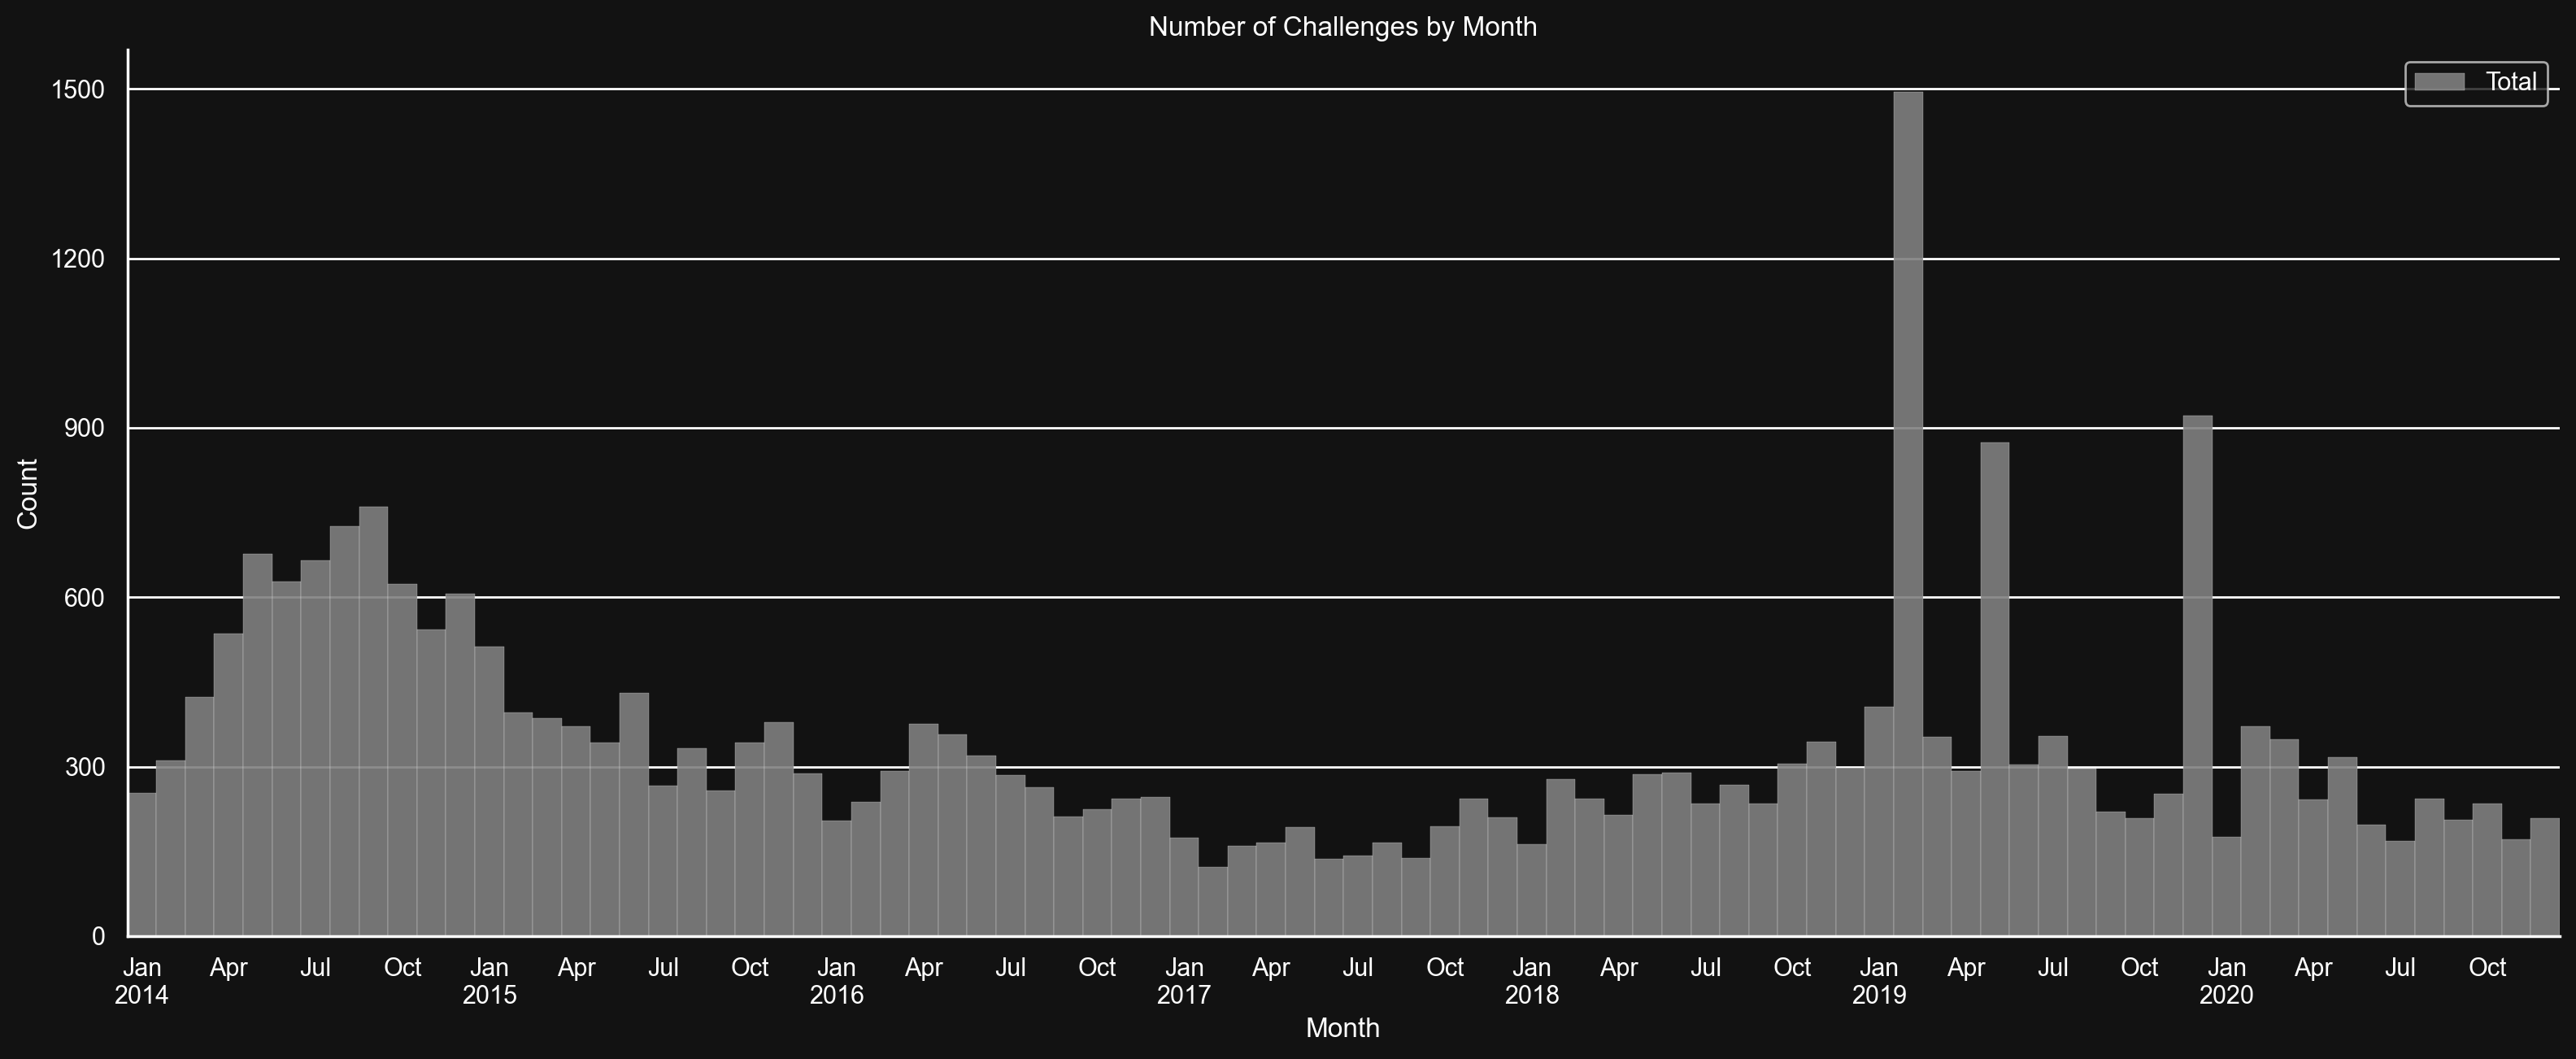

In [7]:
cha_cnt_month_df = pd.DataFrame.from_records(
    data=DB.TopcoderMongo.get_challenge_count('month', '%Y-%m', S.STATUS[:-2]),
).set_index(['month', 'status']).sort_index()

data = cha_cnt_month_df.groupby('month').sum()

fig, ax = plt.subplots(1, 1, figsize=(16, 6.67), dpi=200)
sns.despine()

# abnormal_palette = data['count'].apply(lambda cnt: 'grey' if cnt < 800 else 'red').tolist()

sns.barplot(
    x=data.index,
    y=data['count'],
    linewidth=0.1,
    color='grey',
    alpha=0.9,
    label='Total',
#     palette=abnormal_palette,
    ax=ax,
)

index_tup = [dt_str.split() for dt_str in data.index.strftime('%Y %b')]
xticklabels = []
for year, month in index_tup:
    if month == 'Jan':
        xticklabels.append(f'{month}\n{year}')
    elif month in ['Apr', 'Jul', 'Oct']:
        xticklabels.append(month)
    else:
        xticklabels.append(' ')
        
ax.set_xticklabels(xticklabels)
ax.set_yticks(list(range(0, 1501, 300)))
ax.set_yticklabels(list(range(0, 1501, 300)))
ax.legend()

ax.set_title('Number of Challenges by Month')
ax.set_xlabel('Month')
ax.set_ylabel('Count')

for p in ax.patches:
    p.set_width(1)
    p.set_x(p.get_x() - 0.1)
    
if SAVEFIG:
    fig.savefig(PATH / 'num_of_challenge_month.png', dpi='figure', transparent=TRANSPARENT)

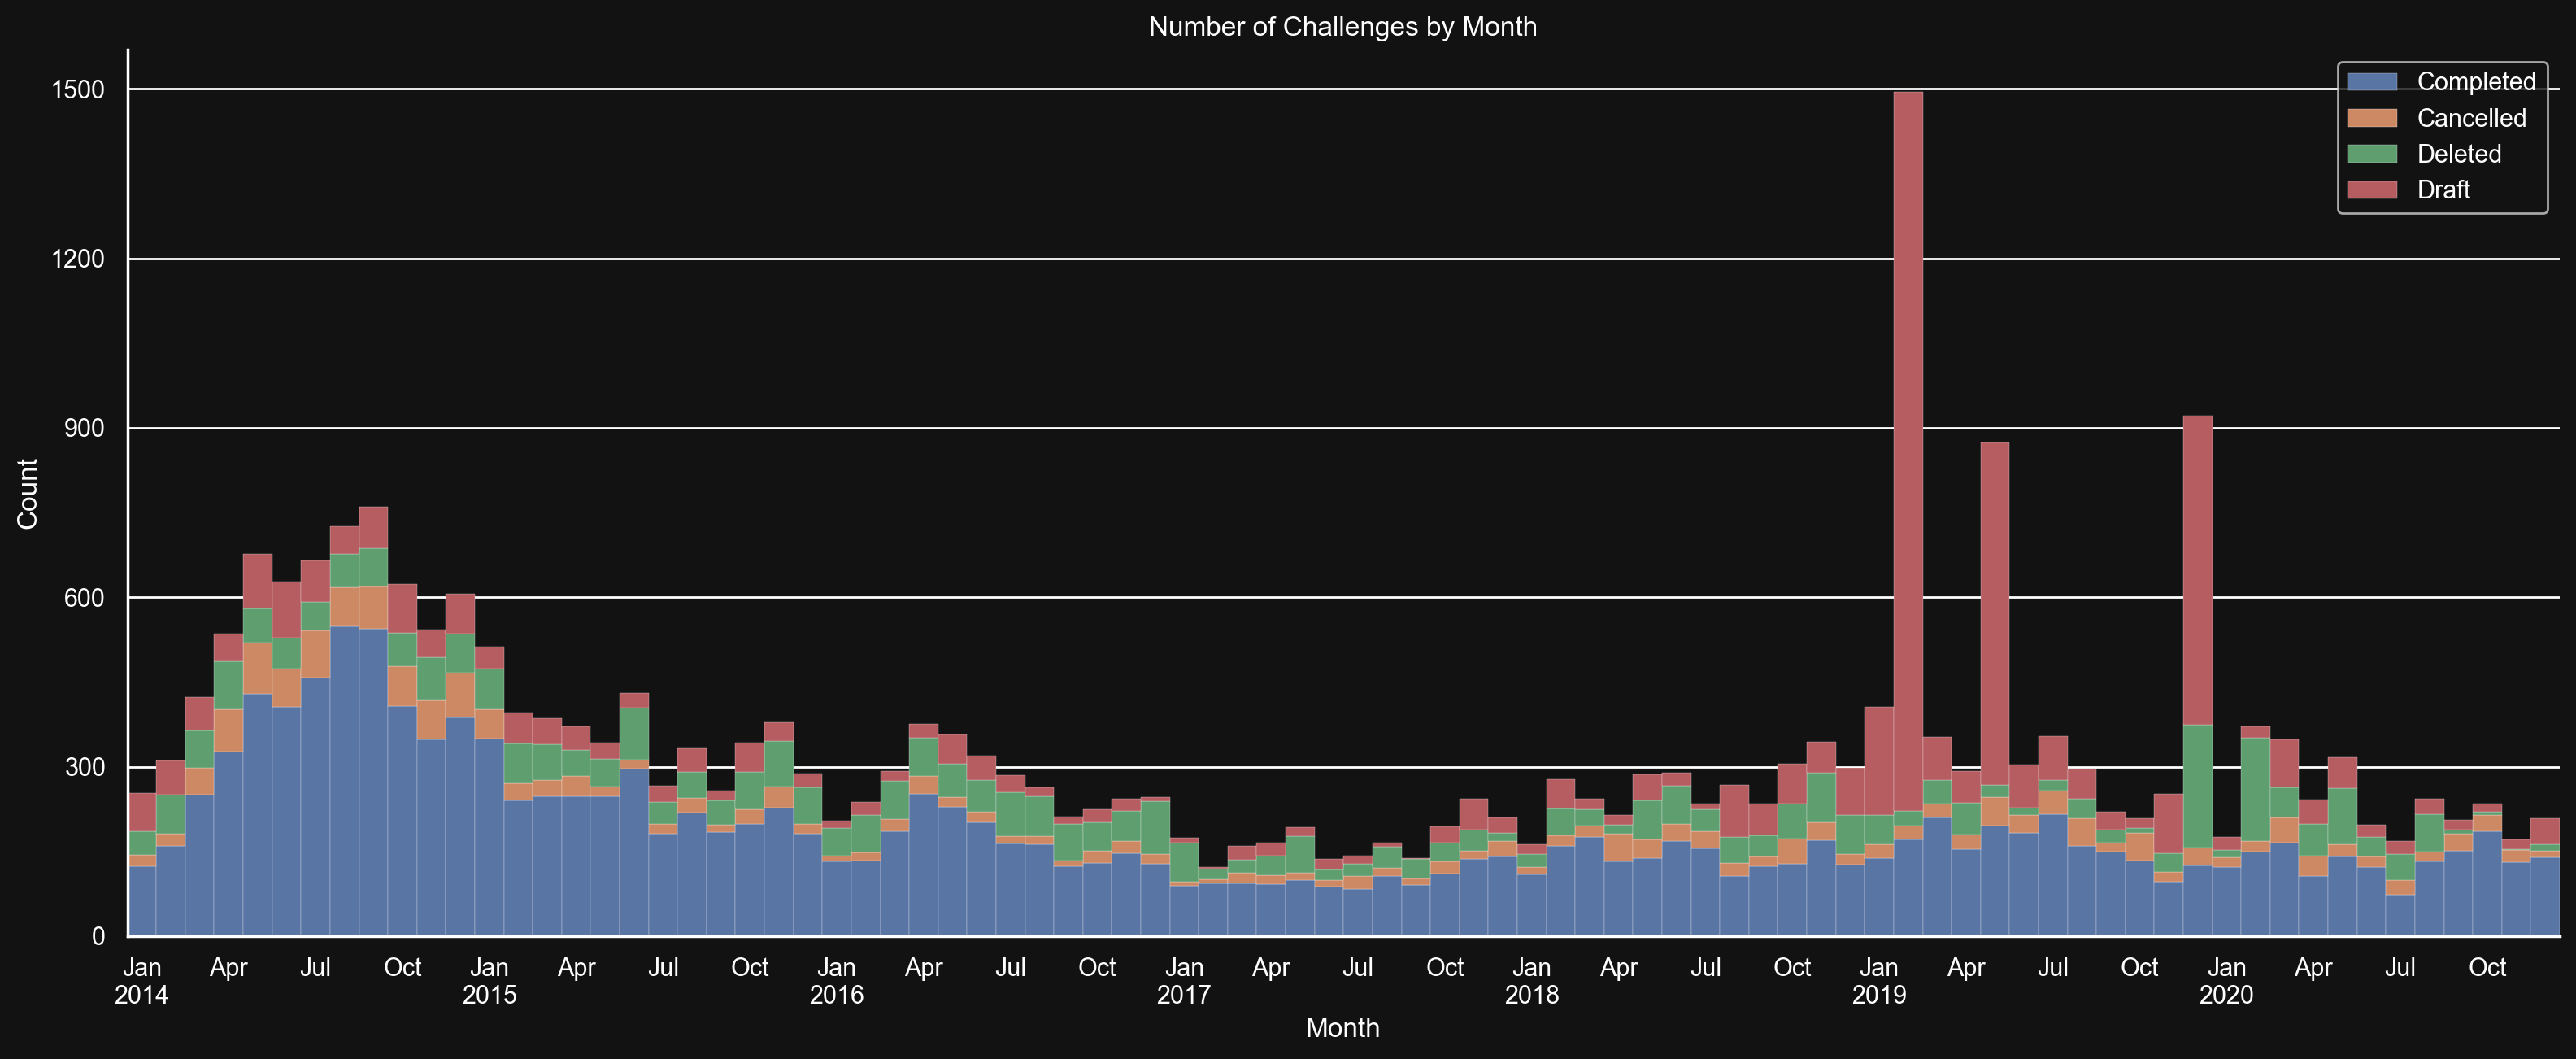

In [8]:
challenge_count_by_month = defaultdict(dict)
for idx, status in enumerate(S.STATUS[:-2]):
    challenge_count_by_month[status]['data'] = cha_cnt_month_df.loc[(slice(None), status), :].reset_index('status', drop=True)
    challenge_count_by_month[status]['color'] = color_palette[idx]
    if idx == 0:
        challenge_count_by_month[status]['bottom'] = pd.DataFrame({'count': 0}, index=cha_cnt_month_df.index.get_level_values('month').unique())
        
    else:
        challenge_count_by_month[status]['bottom'] = cha_cnt_month_df.loc[(slice(None), S.STATUS[:idx]), :].groupby('month').sum()

fig, ax = plt.subplots(1, 1, figsize=(16, 6.67), dpi=200)
sns.despine()
        
for status, data_dct in challenge_count_by_month.items():
    sns.barplot(
        x=data_dct['data'].index.strftime('%Y-%m'),
        y=data_dct['data']['count'],
        bottom=data_dct['bottom']['count'],
        color=data_dct['color'],
        linewidth=0.1,
        label=status,
        ax=ax,
    )
    
ax.set_xticklabels(xticklabels)
ax.set_yticks(list(range(0, 1501, 300)))
ax.set_yticklabels(list(range(0, 1501, 300)))
ax.legend()

ax.set_title('Number of Challenges by Month')
ax.set_xlabel('Month')
ax.set_ylabel('Count')

for p in ax.patches:
    p.set_width(1)
    p.set_x(p.get_x() - 0.1)
    
if SAVEFIG:
    fig.savefig(PATH / 'num_of_challenge_month_hue_all.png', dpi='figure', transparent=TRANSPARENT)

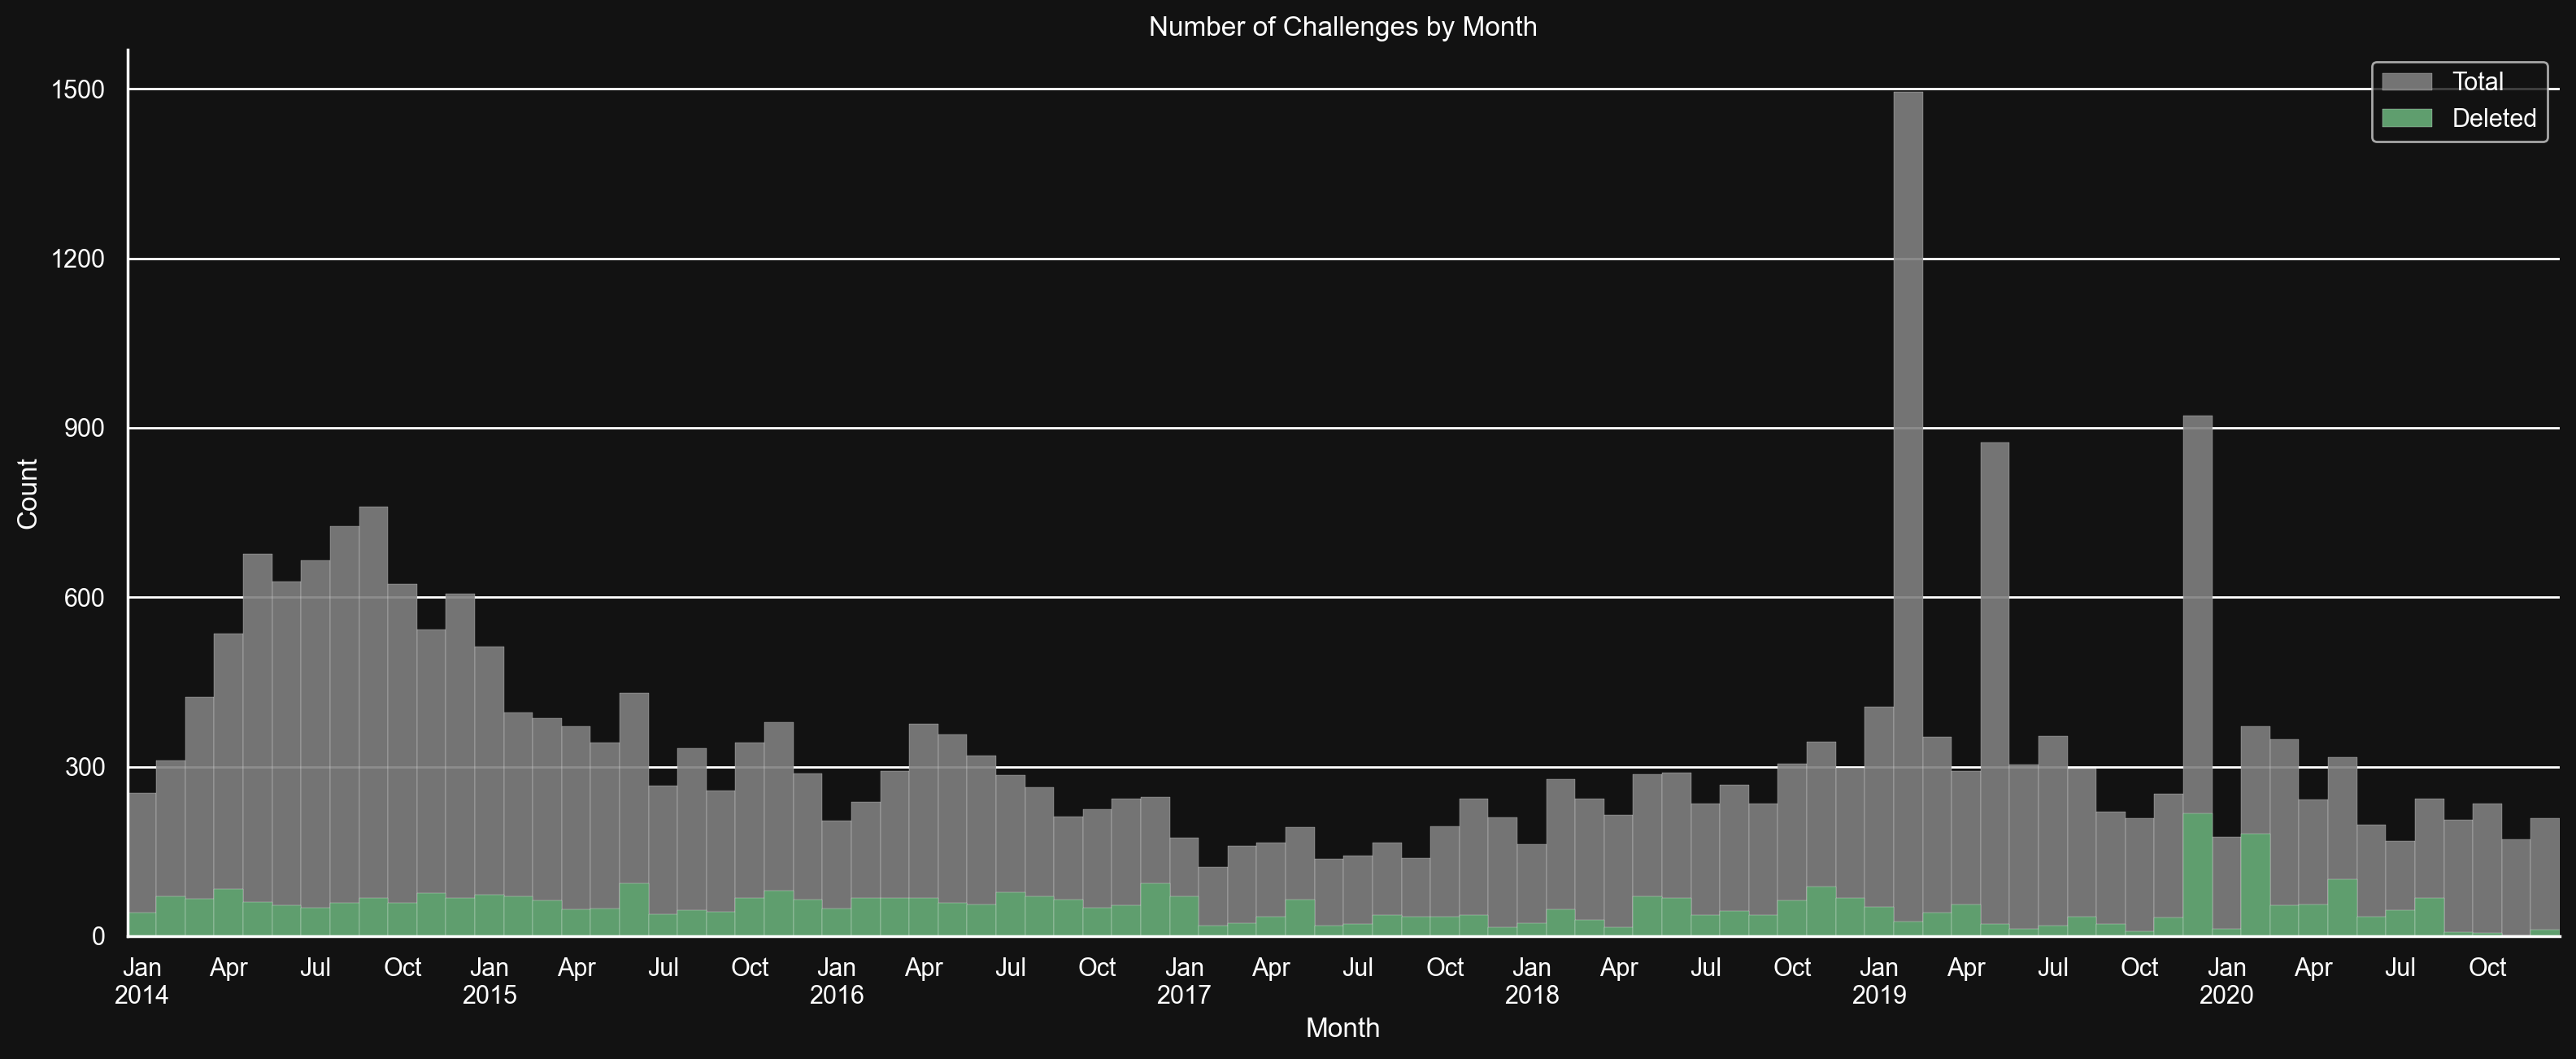

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(16, 6.67), dpi=200)
sns.despine()

status = 'Deleted'
status_data = challenge_count_by_month[status]

sns.barplot(
    x=data.index,
    y=data['count'],
    color='grey',
    linewidth=0.1,
    alpha=0.9,
    label='Total',
    ax=ax,
)

sns.barplot(
    x=status_data['data'].index,
    y=status_data['data']['count'],
    color=status_data['color'],
    linewidth=0.1,
    label=status,
    ax=ax,
)

ax.set_xticklabels(xticklabels)
ax.set_yticks(list(range(0, 1501, 300)))
ax.set_yticklabels(list(range(0, 1501, 300)))
ax.legend()

ax.set_title('Number of Challenges by Month')
ax.set_xlabel('Month')
ax.set_ylabel('Count')

# ax.set_ylim(0, 300)
# ax.set_yticks(list(range(0, 301, 50)))
# ax.set_yticklabels(list(range(0, 301, 50)))

# ax.set_ylim(0, 600)
# ax.set_yticks(list(range(0, 601, 150)))
# ax.set_yticklabels(list(range(0, 601, 150)))

for p in ax.patches:
    p.set_width(1)
    p.set_x(p.get_x() - 0.1)

if SAVEFIG:
    fig.savefig(PATH / f'num_of_challenge_month_hue_{status}.png', dpi='figure', transparent=TRANSPARENT)

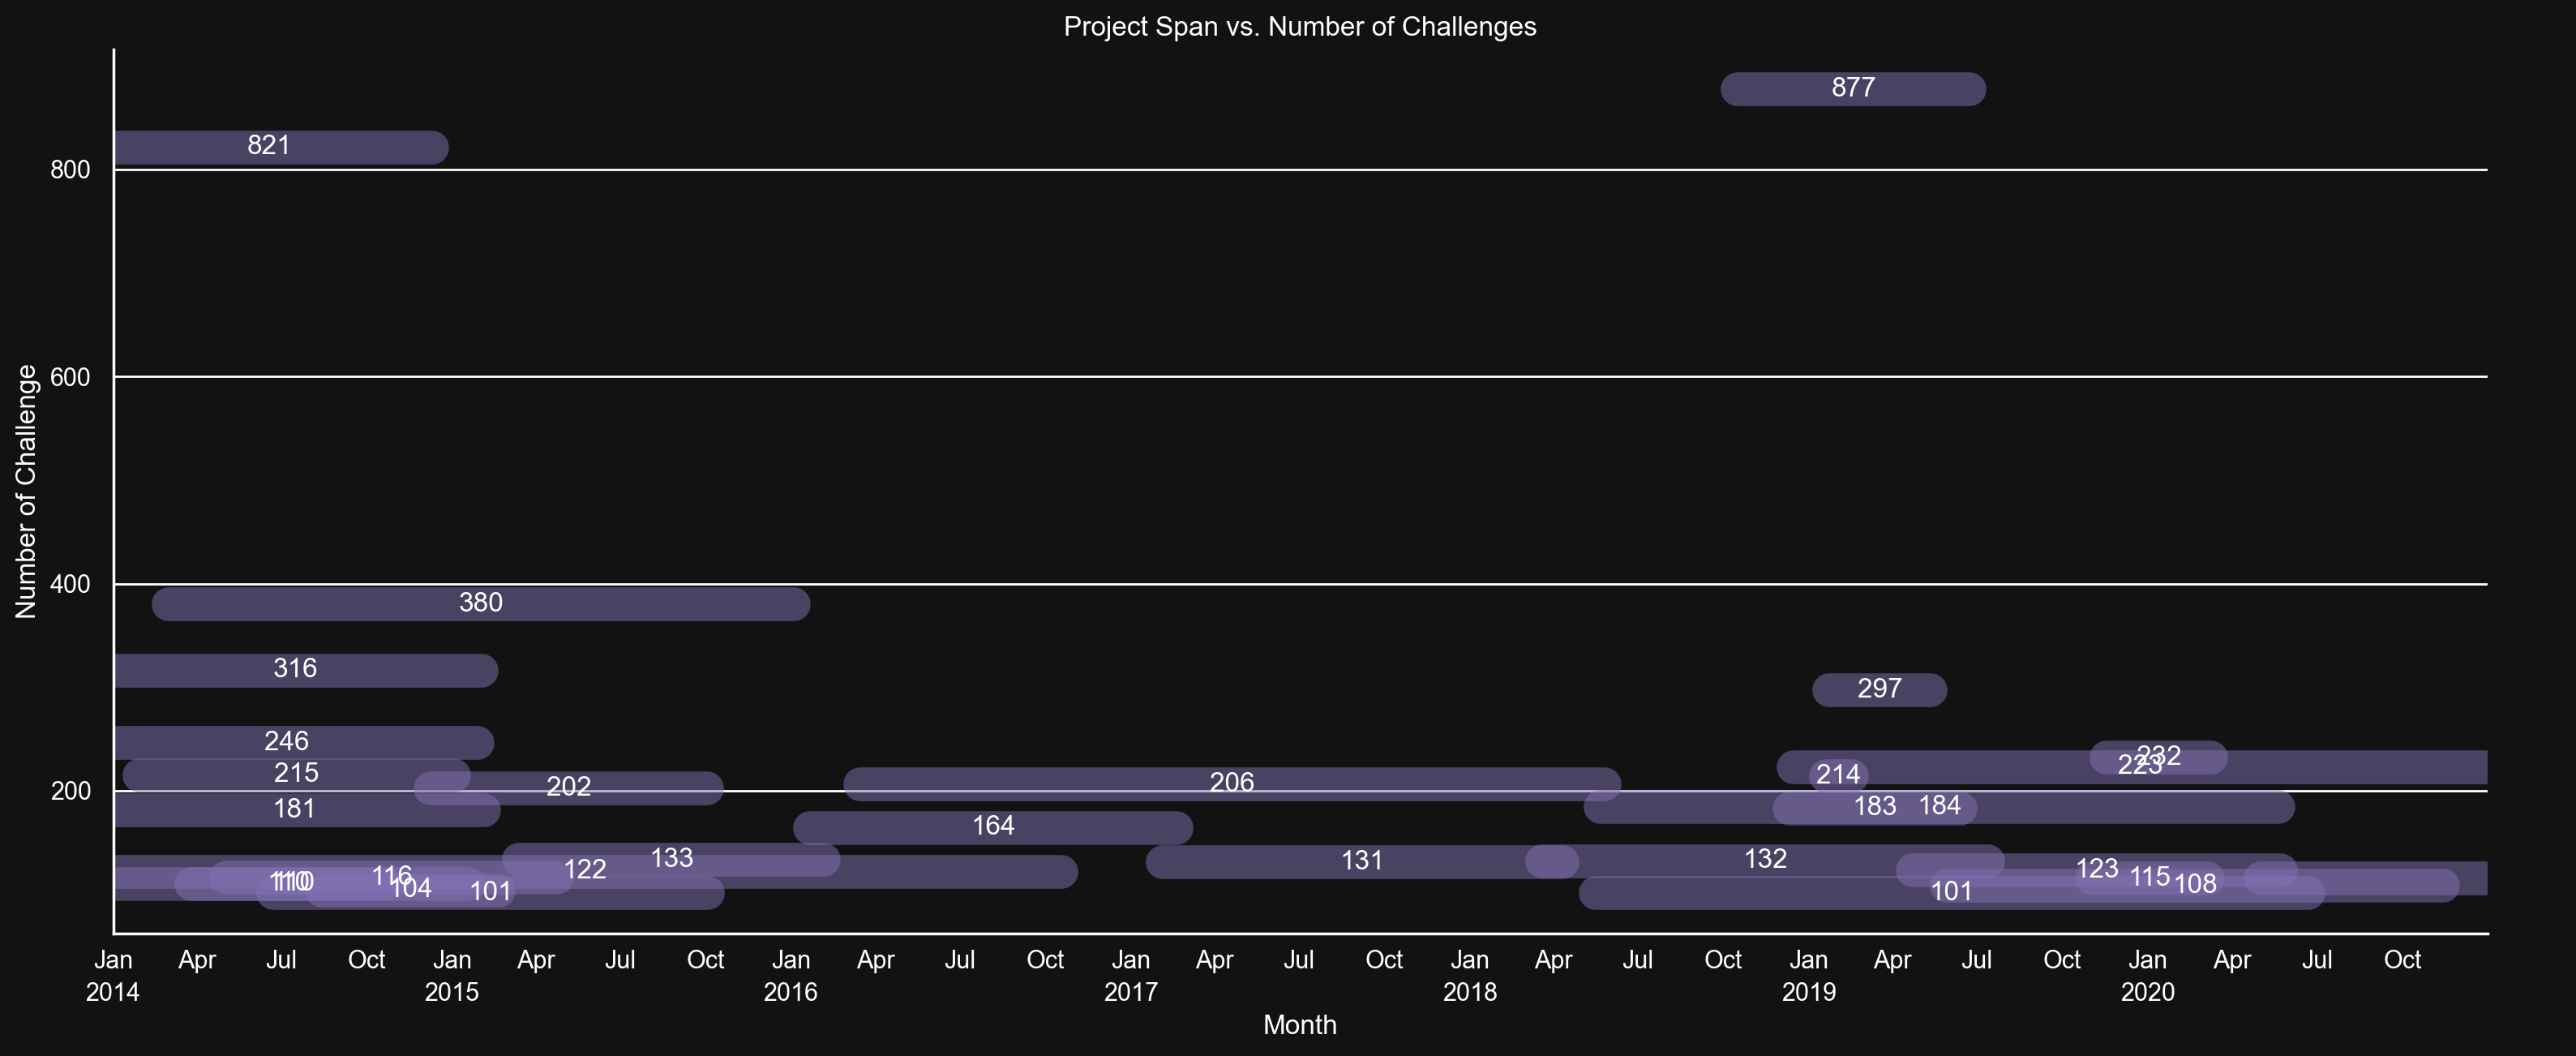

In [10]:
proj_ov_df = pd.DataFrame.from_records(
    DB.TopcoderMongo.run_project_aggregation([
        {'$match': {'id': {'$ne': None}}},
        {'$unwind': '$num_of_challenge'},
        {'$match': {'num_of_challenge.track': 'Total', 'num_of_challenge.count': {'$gte': 100}}},
        {'$project': {'id': True, 'start_date': True, 'end_date': True, 'num_of_challenge': '$num_of_challenge.count'}},
        {'$project': {'_id': False}},
        {'$sort': {'num_of_challenge': -1}}
    ])
)

fig, ax = plt.subplots(1, 1, figsize=(16, 6.67), dpi=200)
sns.despine()

ax.xaxis_date()
ax.set_xlim(U.year_start(2014), U.year_end(2020))
ax.set_yticks(list(range(0, 1000, 200)))

# Configure the xaxis ticks
year_lctr = mdates.YearLocator()
year_fmt = mdates.DateFormatter('\n%Y')
month_lctr = mdates.MonthLocator(bymonth=[1, 4, 7, 10])
month_fmt = mdates.DateFormatter('%b')
ax.xaxis.set_major_locator(year_lctr)
ax.xaxis.set_major_formatter(year_fmt)
ax.xaxis.set_minor_locator(month_lctr)
ax.xaxis.set_minor_formatter(month_fmt)
ax.xaxis.set_remove_overlapping_locs(False)
ax.xaxis.grid(False)

ax.set_title('Project Span vs. Number of Challenges')
ax.set_xlabel('Month')
ax.set_ylabel('Number of Challenge')

for project in proj_ov_df.itertuples(index=False):
    sns.lineplot(
        x=[project.start_date, project.end_date],
        y=[project.num_of_challenge, project.num_of_challenge],
        linewidth=15,
        alpha=0.5,
        color='#8172B3',
        ax=ax,
    )
    
    x = project.start_date + (project.end_date - project.start_date) / 2
    y = project.num_of_challenge
    ax.annotate(project.num_of_challenge, xy=(x, y), xytext=(x, y), ha='center', va='center')
    
if SAVEFIG:
    fig.savefig(PATH / 'project_span_num_of_challenge.png', dpi='figure', transparent=TRANSPARENT)


### Comparison between old track/sub-track to new track and challenge type

In [11]:
query = [
    {'$match': {'legacy.track': {'$exists': True}, 'legacy.sub_track': {'$exists': True}}},
    {
        '$group': {
            '_id': {
                'track': '$track',
                'type': '$type',
                'legacy_track': '$legacy.track',
                'legacy_sub_track': '$legacy.sub_track'
            },
            'count': {'$sum': 1},
        },
    },
    {'$replaceRoot': {'newRoot': {'$mergeObjects': ['$_id', {'count': '$count'}]}}},
]

track_type_df = pd.DataFrame.from_records(
    DB.TopcoderMongo.run_challenge_aggregation(query)
).set_index(['track', 'type', 'legacy_track', 'legacy_sub_track']).sort_index()

In [12]:
track_type_df.loc[track_type_df.index.get_level_values('track') == 'Development', :]

count
track       type         legacy_track legacy_sub_track                
Development Challenge    DEVELOP      ARCHITECTURE                 325
                                      ASSEMBLY_COMPETITION        2214
                                      CODE                        7750
                                      CONCEPTUALIZATION             53
                                      CONTENT_CREATION              57
                                      COPILOT_POSTING              216
                                      DESIGN                        15
                                      DEVELOPMENT                   25
                                      PROCESS                        2
                                      REPORTING                      1
                                      RIA_BUILD_COMPETITION          3
                                      RIA_COMPONENT_COMPETITION      1
                                      SPECIFICATION                 36
                                      UI_PROTOTYPE_COMPETITION    1011
            First2Finish DEVELOP      FIRST_2_FINISH              7621
            Task         DEVELOP      FIRST_2_FINISH              3840

In [13]:
track_type_df.groupby(['legacy_track', 'track']).sum()

count
legacy_track track                   
DATA_SCIENCE Data Science           1
DESIGN       Design              3626
DEVELOP      Data Science         492
             Development        23170
             Quality Assurance   1148

In [14]:
(track_type_df
 .loc[track_type_df.index.get_level_values('type').isin(['First2Finish', 'Task']), :]
 .groupby(['type', 'legacy_sub_track'])
 .sum())

count
type         legacy_sub_track            
First2Finish DESIGN_FIRST_2_FINISH    487
             FIRST_2_FINISH          7623
Task         DESIGN_FIRST_2_FINISH     46
             FIRST_2_FINISH          3843

In [15]:
(track_type_df
 .loc[track_type_df.index.get_level_values('legacy_sub_track').isin(['FIRST_2_FINISH', 'DESIGN_FIRST_2_FINISH']), :]
 .groupby(['legacy_sub_track', 'type'])
 .sum())

count
legacy_sub_track      type               
DESIGN_FIRST_2_FINISH First2Finish    487
                      Task             46
FIRST_2_FINISH        First2Finish   7623
                      Task           3843

In [16]:
(track_type_df
 .loc[track_type_df.index.get_level_values('track') == 'Quality Assurance', :]
 .groupby(['track', 'type', 'legacy_sub_track'])
 .sum())

count
track             type         legacy_sub_track       
Quality Assurance Challenge    BUG_HUNT            975
                               TEST_SCENARIOS       50
                               TEST_SUITES         121
                  First2Finish FIRST_2_FINISH        1
                  Task         FIRST_2_FINISH        1

In [17]:
groupby_legacy_track = track_type_df.groupby('legacy_track').sum().sort_index(ascending=False).reset_index()
groupby_track = (track_type_df.groupby('track')
                 .sum()
                 .reindex([
                     'Development',
                     'Quality Assurance',
                     'Design',
                     'Data Science'
                 ])
                 .reset_index()
                )
groupby_both = track_type_df.groupby(['track', 'legacy_track']).sum()

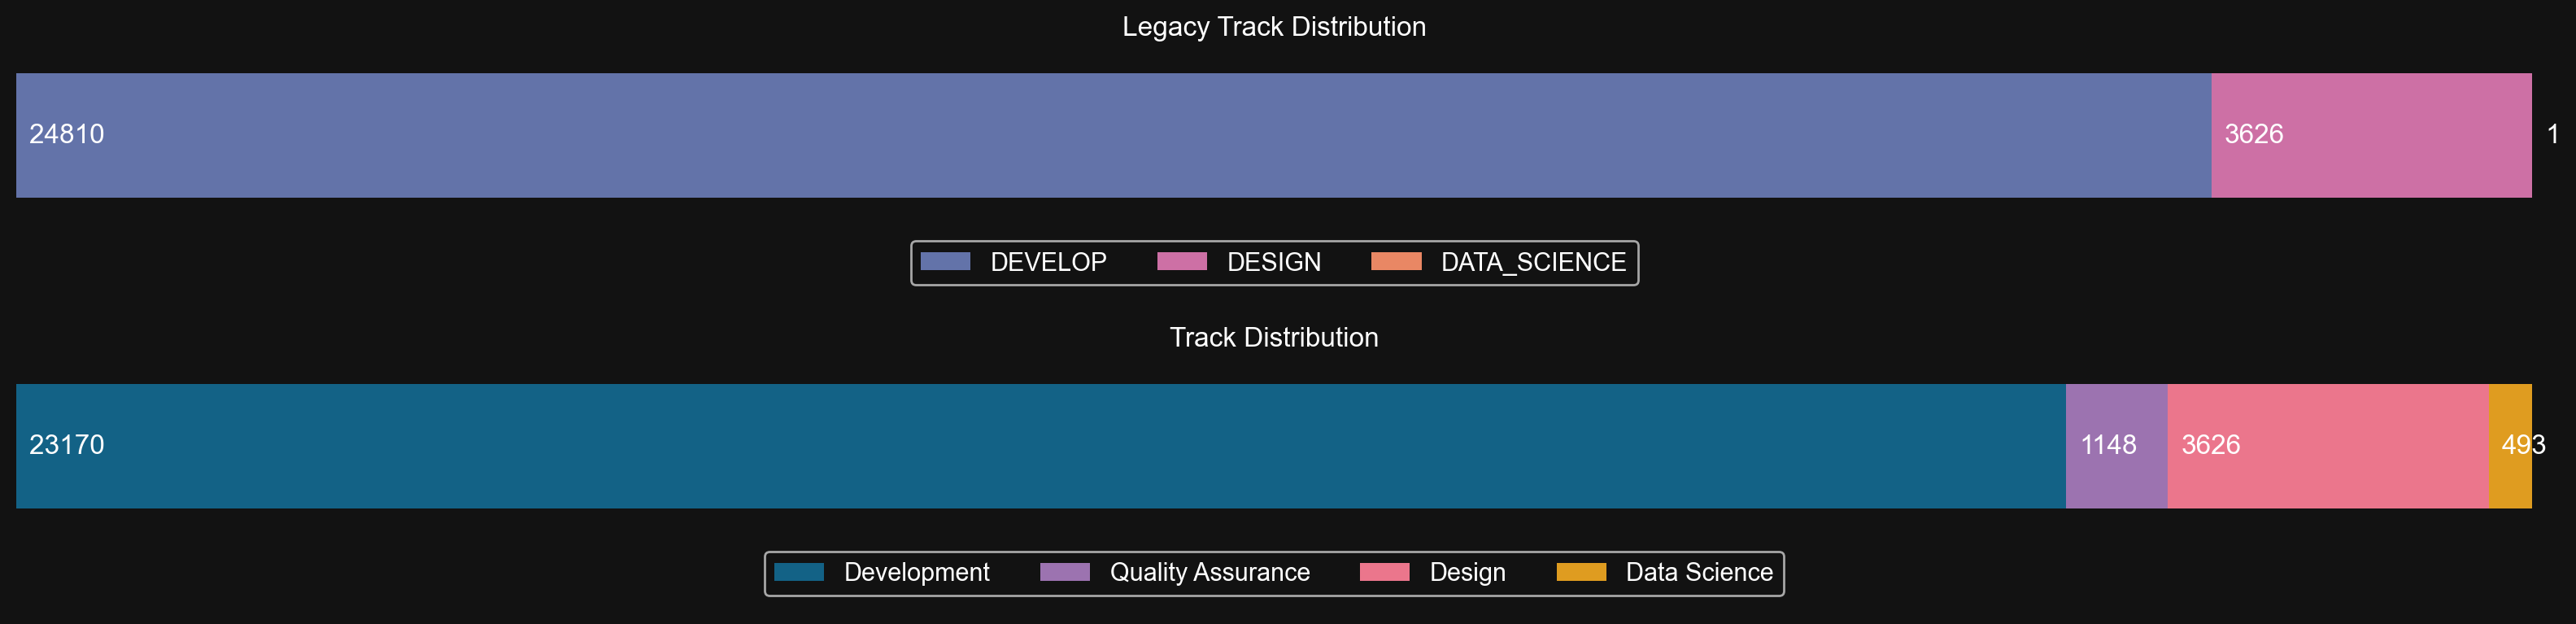

In [18]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(16, 4), dpi=200, sharex=True)

legacy_track_color = {
    'DEVELOP': '#586DB4',
    'DESIGN': '#DD60A7',
    'DATA_SCIENCE': '#FF7D4E',
}
track_color = ['#006999', '#9F69BA', '#FF6280', '#FFA600']

# ------------------ Plot legacy track distro ------------------

ax0.set_title('Legacy Track Distribution')
for row in groupby_legacy_track.itertuples():
    left = 0 if row.Index == 0 else groupby_legacy_track.loc[groupby_legacy_track.index < row.Index, 'count'].sum()
    sns.barplot(
        x=[row.count],
        y=[''],
        label=row.legacy_track,
        color=legacy_track_color[row.legacy_track],
        left=left,
        linewidth=0,
        ax=ax0,
    )
    
for p in ax0.patches:
    p.set_height(0.5)
    p.set_y(-0.4)
    
    cnt = int(p.get_width())
    x = p.get_x()
    y = p.get_y() + p.get_height() / 2
    ax0.annotate(int(cnt), xy=(x, y), xytext=(x + 150, y), color='white', ha='left', va='center')
    
# ------------------ Plot track distro ------------------

ax1.set_title('Track Distribution')
for row in groupby_track.itertuples():
    left = 0 if row.Index == 0 else groupby_track.loc[groupby_track.index < row.Index, 'count'].sum()
    sns.barplot(
        x=[row.count],
        y=[''],
        label=row.track,
        color=track_color[row.Index],
        left=left,
        linewidth=0,
        ax=ax1,
    )

for p in ax1.patches:
    p.set_height(0.5)
    p.set_y(-0.4)
    
    cnt = int(p.get_width())
    x = p.get_x()
    y = p.get_y() + p.get_height() / 2
    ax1.annotate(int(cnt), xy=(x, y), xytext=(x + 150, y), color='white', ha='left', va='center')
    
for ax in (ax0, ax1):
    sns.despine(ax=ax, left=True, bottom=True)
    ax.grid(False)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, ncol=len(handles), loc=8)

    ax.set_xticks([])
    ax.set_xlim(0, track_type_df['count'].sum())
    
fig.tight_layout()

if SAVEFIG:
    fig.savefig(PATH / 'challenge_distro_by_track.png', dpi='figure', transparent=TRANSPARENT)


### Explore the relationship between tracks and prize set

**SCOPE**: The **_placement_** prize sets of **_Completed_** **_Development_** **_Challenge_** that **_ended before end of 2020_**.

We are going to explore the prize set distribution in following angles:

1. Is there a different distribution of **_number of placements_** by type | legacy sub track?
2. Is there a different distribution of prize amount between **total prize** and **sum of first 2 placements**?
3. Does the project impact the distribution in anyway? i.e. different distro caused by number of challenges in a project?

In [19]:
query = [
    {
        '$match': {
            'track': 'Development',
            'status': 'Completed',
            'end_date': {'$lte': U.year_end(2020)},
            'legacy.sub_track': {'$exists': True},
            'project_id': {'$ne': None},
        }
    },
    {'$unwind': '$prize_sets'},
    {'$match': {'prize_sets.type': 'placement'}},
    {
        '$project': {
            'id': True,
            'type': True,
            'legacy_sub_track': '$legacy.sub_track',
            'total_prize': {'$sum': '$prize_sets.prizes.value'},
            'top2_prize': {'$sum': {'$slice': ['$prize_sets.prizes.value', 2]}},
            'top1_prize': {'$arrayElemAt': ['$prize_sets.prizes.value', 0]},
            'num_of_placement': {'$size': '$prize_sets.prizes'}
        }
    },
    {'$match': {'num_of_placement': {'$gt': 0}}},
    {'$project': {'_id': False}},
]

prize_set_df = (pd.DataFrame
                .from_records(DB.TopcoderMongo.run_challenge_aggregation(query))
                .sort_values(['type', 'legacy_sub_track'])
#                 .reset_index(drop=True))
                .set_index('id'))

# This query below is added into the TopcoderMongo classmethod
query = [
    {'$match': {'$expr': {'$in': ['Development', '$tracks']}}},
    {'$unwind': '$num_of_challenge'},
    {'$match': {'num_of_challenge.track': 'Development'}},
    {'$unwind': '$completion_ratio'},
    {'$match': {'completion_ratio.track': 'Development'}},
    {
        '$set': {
            'dev_cha_lst': {
                '$filter': {
                    'input': '$challenge_lst',
                    'as': 'cha',
                    'cond': {'$eq': ['$$cha.track', 'Development']},
                },
            },
            'num_of_comp_dev_challenge': { # number of completed development challenge
                '$size': {
                    '$filter': {
                        'input': '$challenge_lst',
                        'as': 'cha',
                        'cond': {'$and': [{'$eq': ['$$cha.track', 'Development']}, {'$eq': ['$$cha.status', 'Completed']}]},
                    }
                },
            },
        },
    },
    {
        '$project': {
#             'id': True,
            'num_of_challenge': '$num_of_challenge.count',
            'completion_ratio': '$completion_ratio.ratio',
            'num_of_comp_dev_challenge': True,
            'challenge_lst': '$dev_cha_lst.id',
        }
    },
    {
        '$set': {
            'num_of_cha_range': {'$switch': {'branches': [
                {'case': {'$and': [{'$gte': ['$num_of_challenge', 0]}, {'$lte': ['$num_of_challenge', 9]}]}, 'then': '0~9'},
                {'case': {'$and': [{'$gte': ['$num_of_challenge', 10]}, {'$lte': ['$num_of_challenge', 49]}]}, 'then': '10~49'},
                {'case': {'$and': [{'$gte': ['$num_of_challenge', 50]}, {'$lte': ['$num_of_challenge', 99]}]}, 'then': '50~99'},
                {'case': {'$gte': ['$num_of_challenge', 100]}, 'then': '>=100'},
            ]}}
        },
    },
    {
        '$group': {
            '_id': '$num_of_cha_range',
            'num_of_project': {'$sum': 1},
            'num_of_challenge': {'$sum': '$num_of_challenge'},
            'num_of_comp_challenge': {'$sum': '$num_of_comp_dev_challenge'},
            'avg_completion_ratio': {'$avg': '$completion_ratio'},
            'all_challenge_lst': {'$push': '$challenge_lst'}
        },
    },
    {
        '$project': {
            'tag': '$_id',
            'num_of_project': True,
            'num_of_challenge': True,
            'num_of_comp_challenge': True,
            'avg_completion_ratio': {'$round': ['$avg_completion_ratio', 3]},
            'challenge_lst': {
                '$reduce': {
                    'input': '$all_challenge_lst',
                    'initialValue': [],
                    'in': {'$concatArrays': ['$$value', '$$this']}
                }
            }
        },
    },
    {'$project': {'_id': False}}
]

project_tag_df = (pd.DataFrame
                  .from_records(DB.TopcoderMongo.run_project_aggregation(query))
                  .sort_values('num_of_project', ascending=False)
                  .set_index('tag'))

In [20]:
project_tag_df.sum()

num_of_project                                                        2177
num_of_challenge                                                     20669
num_of_comp_challenge                                                11234
avg_completion_ratio                                                   2.2
challenge_lst            [5de3d511-953f-494c-8b7f-624ac614512c, 14c4eab...
dtype: object

In [21]:
(project_tag_df
 .reindex(['num_of_project', 'num_of_challenge', 'num_of_comp_challenge', 'avg_completion_ratio'], axis=1))

,num_of_project,num_of_challenge,num_of_comp_challenge,avg_completion_ratio
tag,,,,
0~9,1723,4701,2479,0.492
10~49,383,7173,4011,0.575
50~99,45,3140,1827,0.571
>=100,26,5655,2917,0.562


In [22]:
def get_prize_majority(percentile = 0.95):
    prize_majority = pd.concat(
        [prize_set_df.quantile(percentile),
         *[prize_set_df.loc[prize_set_df.type == t, :].quantile(percentile) for t in prize_set_df.type.unique()]
        ], axis=1)
    prize_majority.columns = ['All', 'Challenge', 'First2Finish', 'Task']

    return (prize_majority, percentile)
    

In [23]:
get_prize_majority()[0]

,All,Challenge,First2Finish,Task
total_prize,2700.0,3000.0,1000.0,850.25
top2_prize,2700.0,2700.0,1000.0,850.25
top1_prize,1800.0,1800.0,1000.0,850.25
num_of_placement,2.0,3.0,1.0,1.00


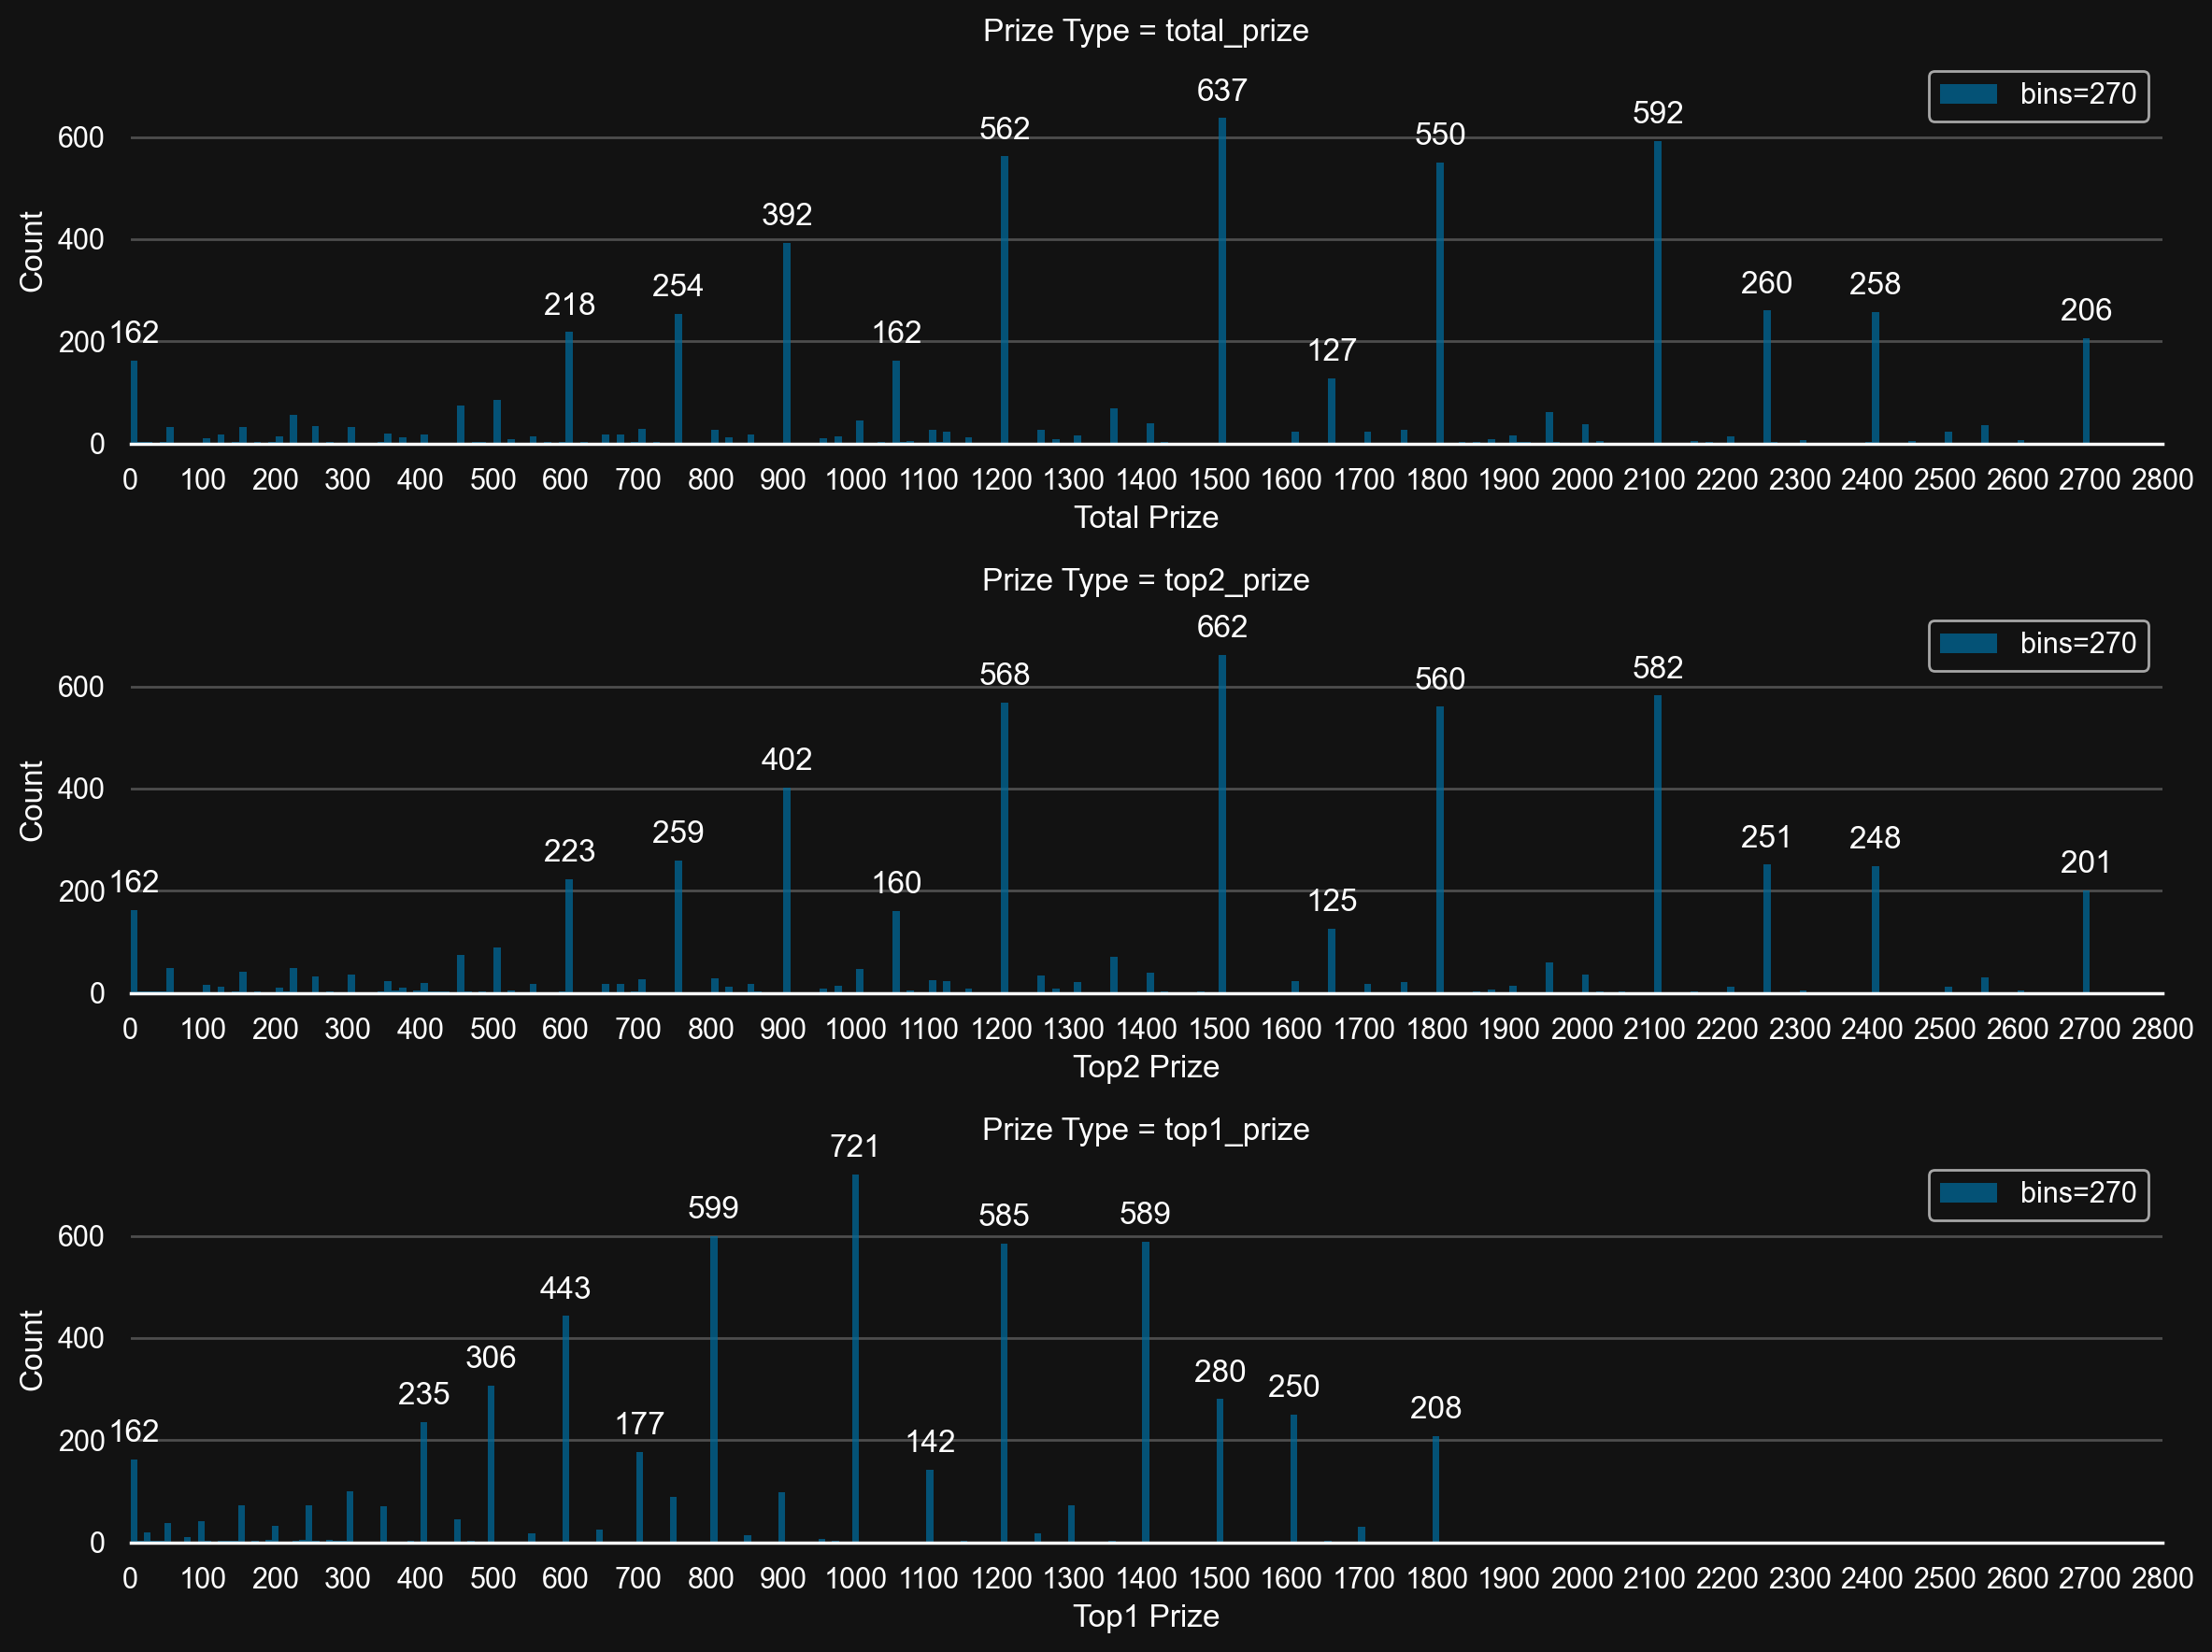

In [24]:
fig, axes = plt.subplots(3, 1, figsize=(12, 9), dpi=200, sharex=False, sharey=True)

prz_maj_df, percentile = get_prize_majority(0.95)
percentile_val = prz_maj_df.loc['total_prize', 'All']
hist_bins = int(percentile_val / 10)

challenge_type = 'Challenge'
for row, prz_type in enumerate(['total_prize', 'top2_prize', 'top1_prize']):
    ax = axes[row]
    data = prize_set_df.loc[
        (prize_set_df['total_prize'] <= percentile_val) & (prize_set_df['type'] == challenge_type),
        prz_type
    ]

    sns.histplot(
        x=data,
        bins=hist_bins,
        label=f'bins={hist_bins}',
        linewidth=0,
        color='#006999',
        ax=ax,
    )

    sns.despine(ax=ax, left=True)
    ax.grid(False, axis='x')
    ax.grid(True, axis='y', alpha=0.25)
    ax.xaxis.set_major_locator(mticker.MultipleLocator(100))
    ax.set_title(f'Prize Type = {prz_type}')
    ax.set_xlabel(' '.join(w.capitalize() for w in prz_type.split('_')))
    ax.set_xlim(0, percentile_val + 100)
    ax.legend()
    
    for p in ax.patches:
        cnt = p.get_height()
        if cnt > 100:
            x = p.get_x() + p.get_width() * 0.5
            y = p.get_height()

            ax.annotate(int(cnt), xy=(x, y), xytext=(x, y + 50), ha='center', va='center')

fig.tight_layout()

if SAVEFIG:
    fig.savefig(PATH / 'challenge_prizes_distro.png', dpi='figure', transparent=TRANSPARENT)

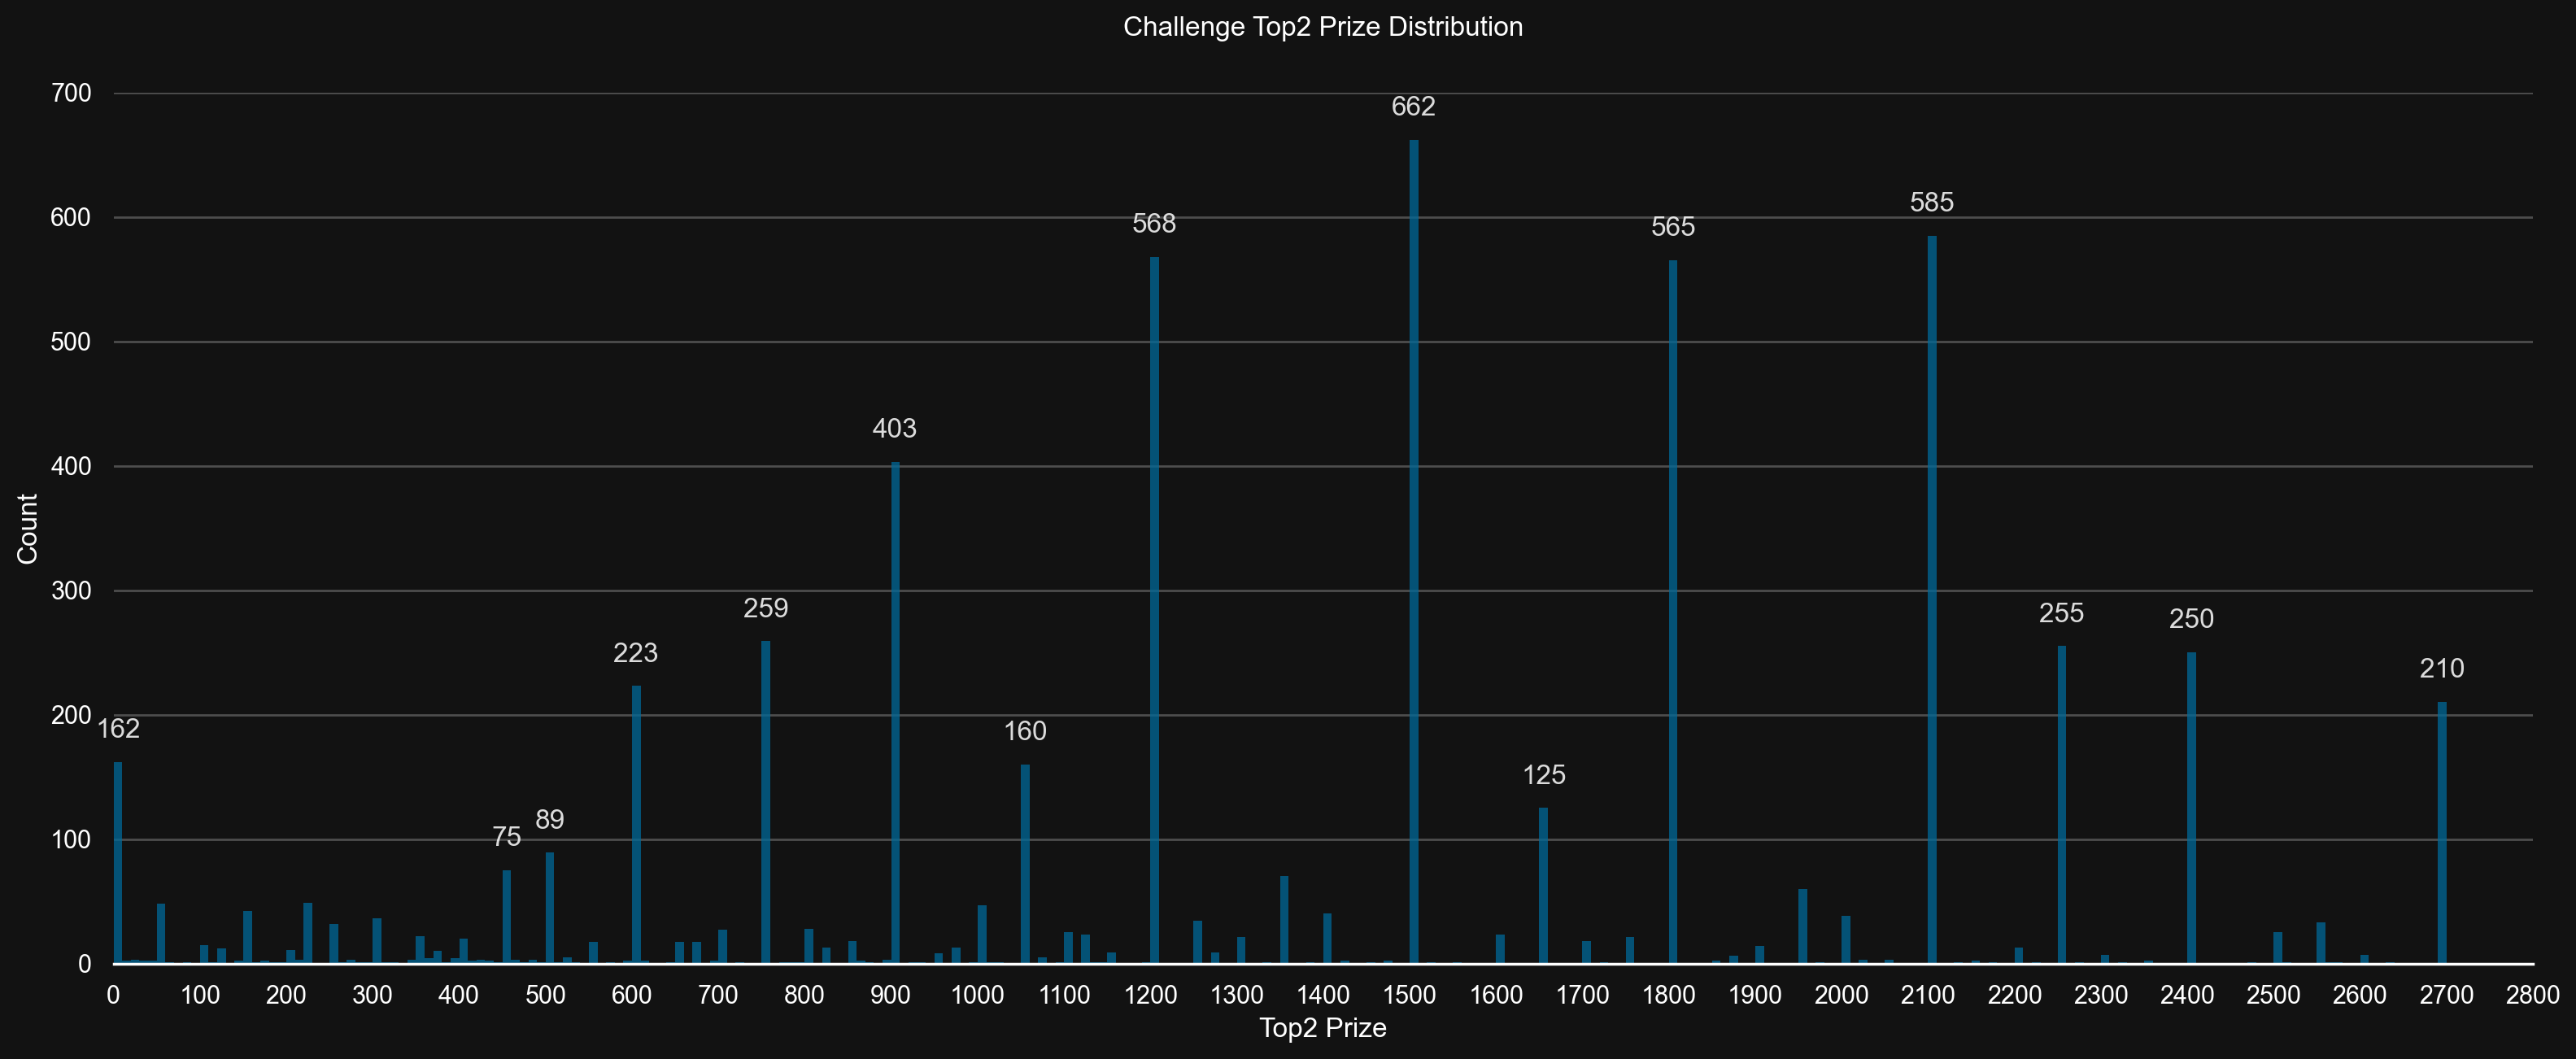

In [25]:
challenge_wproj_tag = pd.concat([
    pd.DataFrame({'id': row.challenge_lst, 'tag': row.tag})
    for row in project_tag_df.reset_index().itertuples()
]).set_index('id')

challenge_top2_prize = prize_set_df.loc[prize_set_df.type == 'Challenge'].reindex(['top2_prize'], axis=1).join(challenge_wproj_tag)

percentile95 = challenge_top2_prize.quantile(0.95)['top2_prize']


fig, ax = plt.subplots(figsize=(16, 6.67), dpi=200)

sns.histplot(
    x=challenge_top2_prize.loc[challenge_top2_prize.top2_prize <= percentile95].top2_prize,
    bins=int(percentile95 / 10),
    label=f'bins={percentile95 / 10}',
    linewidth=0,
    color='#006999',
    ax=ax,
)
sns.despine(ax=ax, left=True)
ax.grid(False, axis='x')
ax.grid(True, axis='y', alpha=0.25)
ax.xaxis.set_major_locator(mticker.MultipleLocator(100))
ax.set_xlim(0, percentile95 + 100)
ax.set_ylim(0, 700)
ax.set_title('Challenge Top2 Prize Distribution', pad=25)
ax.set_xlabel('Top2 Prize')
ax.set_ylabel('Count')

for p in ax.patches:
    cnt = p.get_height()
    x = p.get_x() + p.get_width() * 0.5
    y = p.get_height()
    
    if cnt >= 75:
        ax.annotate(int(cnt), xy=(x, y), xytext=(x, y + 25), ha='center', va='center', alpha=0.85)



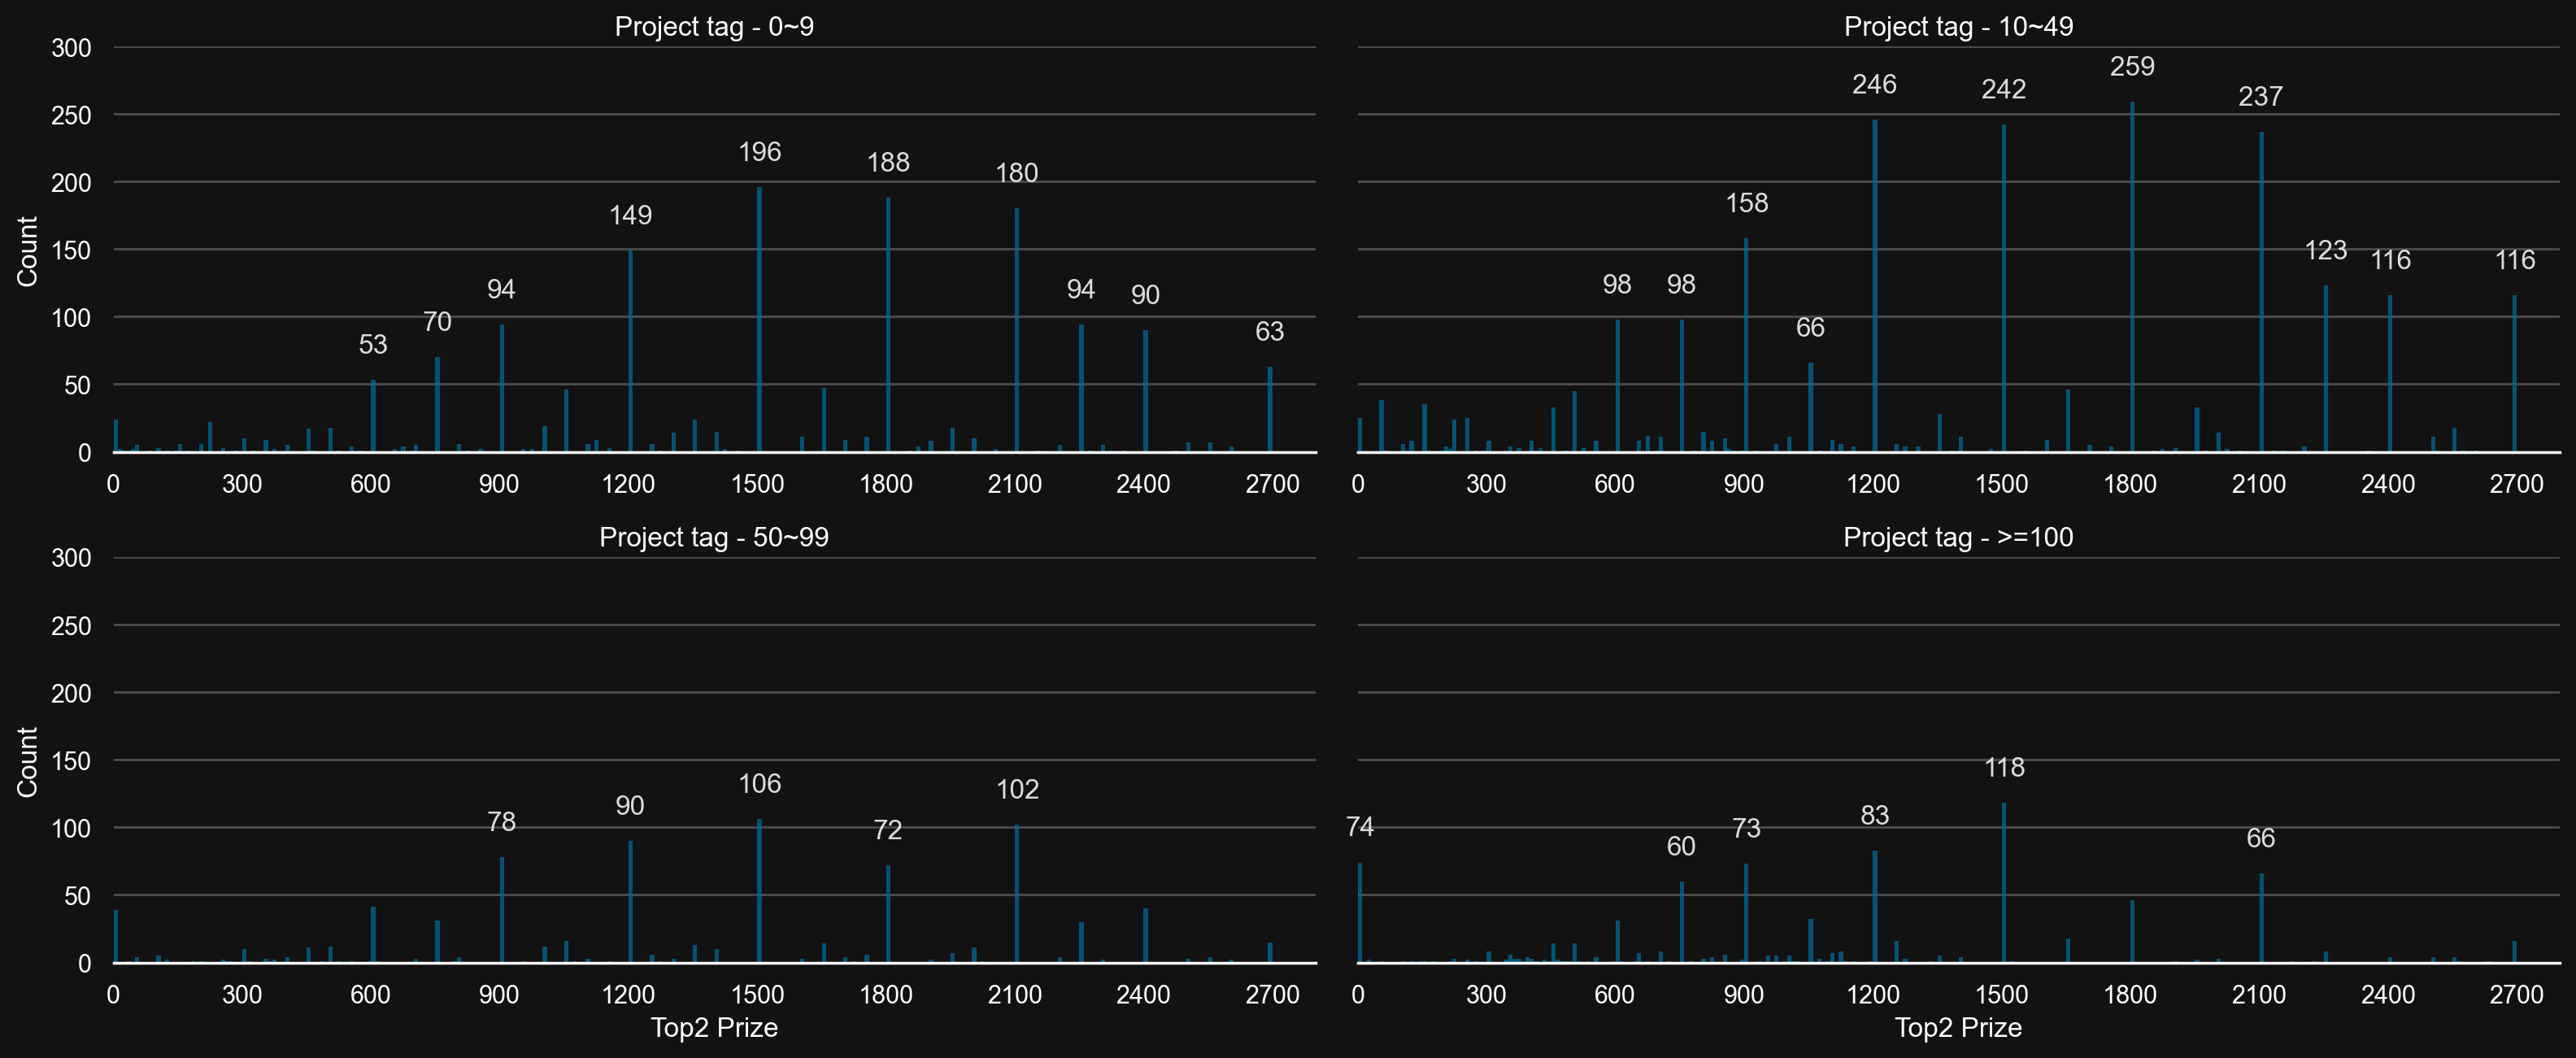

In [26]:
fig, axes = plt.subplots(2, 2, figsize=(16, 6.67), dpi=200, sharey=True)

for idx, tag in enumerate(sorted(challenge_wproj_tag.tag.unique())):
    ax = axes.flat[idx]
    data = challenge_top2_prize.loc[(challenge_top2_prize.top2_prize <= percentile95) & (challenge_top2_prize.tag == tag)].top2_prize

    sns.histplot(
        x=data,
        bins=int(percentile95 / 10),
        label=f'bins={percentile95 / 10}',
        linewidth=0,
        color='#006999',
        ax=ax,
    )
    sns.despine(ax=ax, left=True)
    
    ax.grid(False, axis='x')
    ax.grid(True, axis='y', alpha=0.25)
    ax.xaxis.set_major_locator(mticker.MultipleLocator(300))
#     ax.xaxis.set_major_formatter()
    ax.set_xlim(0, percentile95 + 100)
    ax.set_ylim(0, 300)
    ax.set_title(f'Project tag - {tag}', pad=5)
    ax.set_xlabel('Top2 Prize' if idx > 1 else '')
    ax.set_ylabel('Count')

    for p in ax.patches:
        cnt = p.get_height()
        x = p.get_x() + p.get_width() * 0.5
        y = p.get_height()
        
        if cnt >= 50:
            ax.annotate(int(cnt), xy=(x, y), xytext=(x, y + 25), ha='center', va='center', alpha=0.85)

In [27]:
prz_maj_df

,All,Challenge,First2Finish,Task
total_prize,2700.0,3000.0,1000.0,850.25
top2_prize,2700.0,2700.0,1000.0,850.25
top1_prize,1800.0,1800.0,1000.0,850.25
num_of_placement,2.0,3.0,1.0,1.00


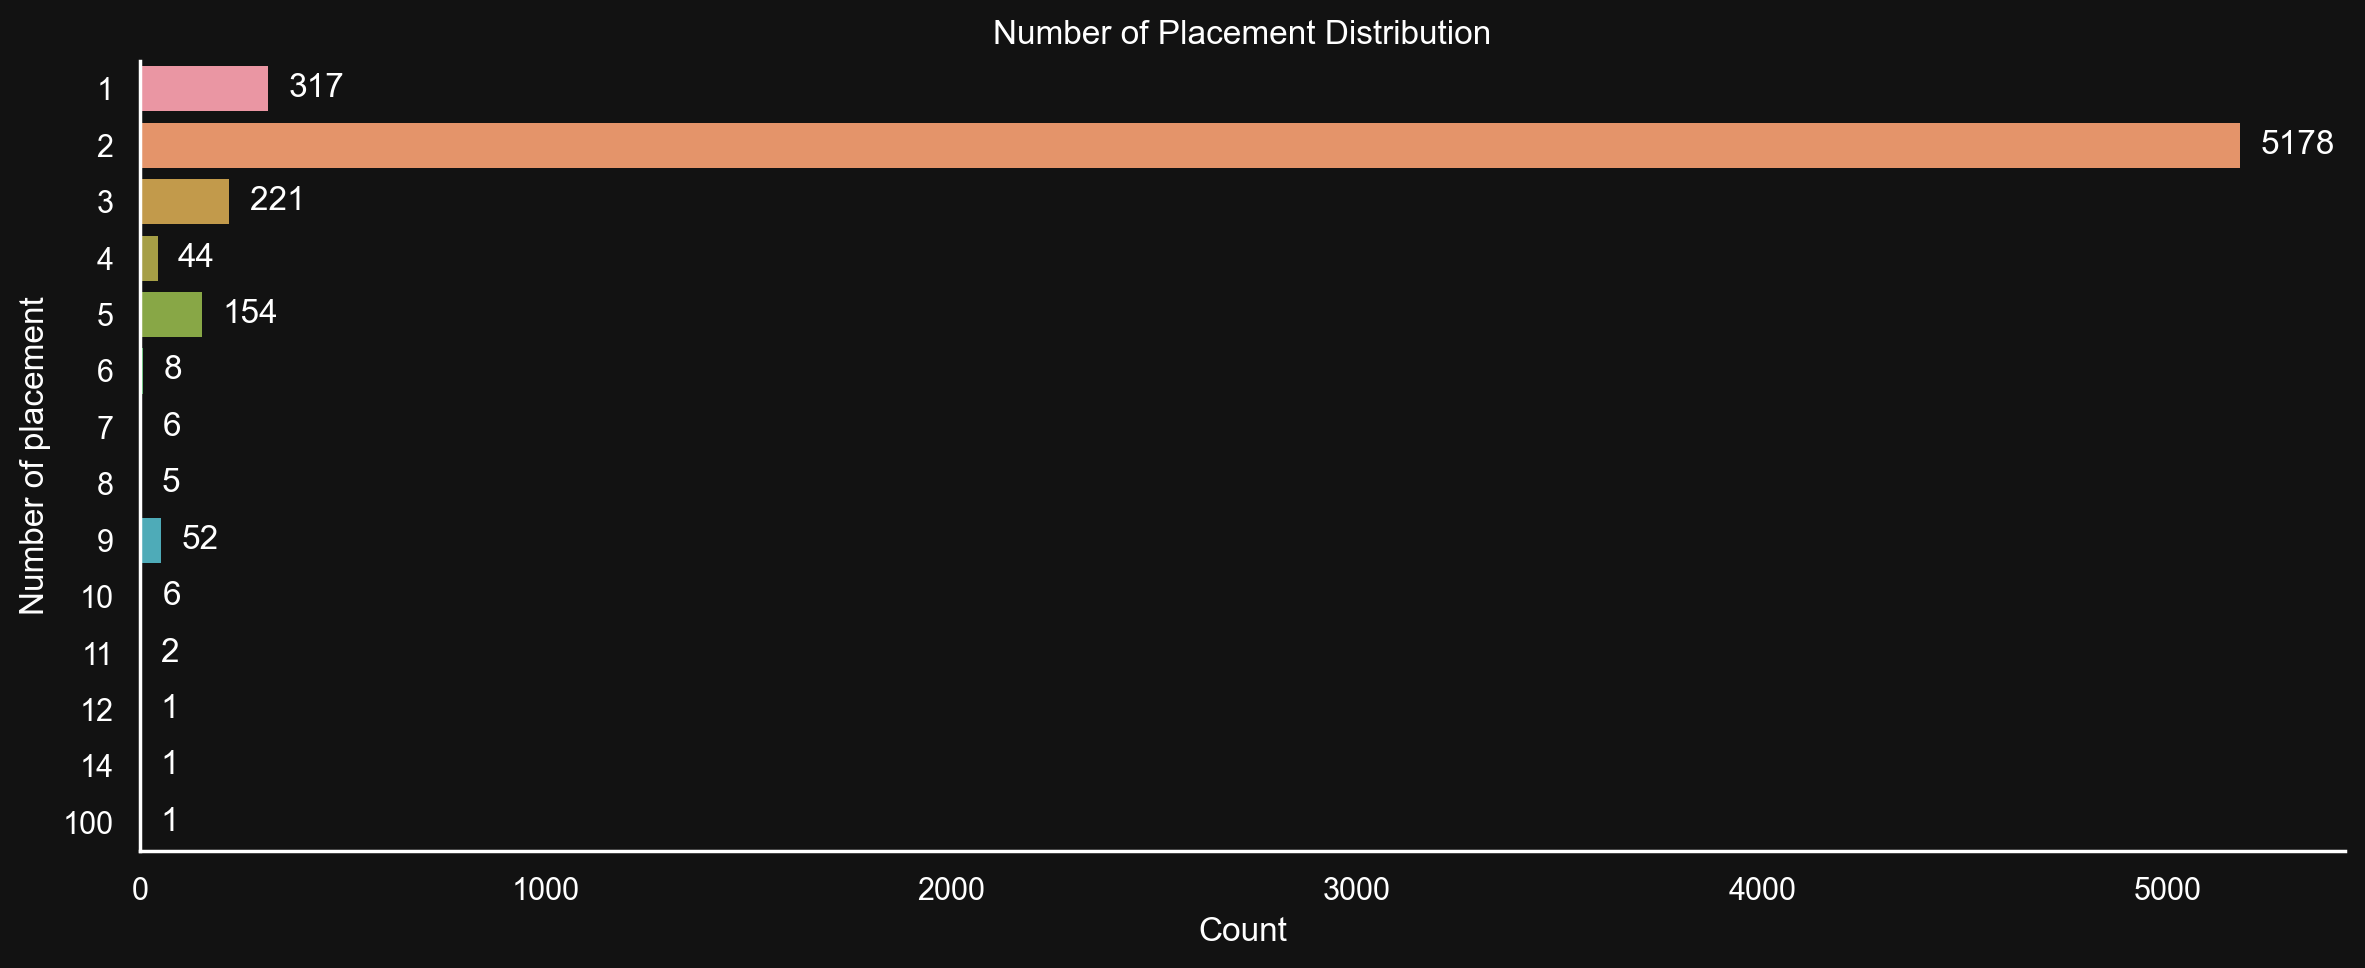

In [28]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=200)

placement_value_count_df = (prize_set_df
                            .loc[prize_set_df.type == 'Challenge', :].num_of_placement
                            .value_counts()
                            .sort_index()
                            .to_frame()
                            .reset_index())
placement_value_count_df.columns = ['num_of_placement', 'count']
placement_value_count_df.astype({'num_of_placement': str, 'count': int})

sns.barplot(
    data=placement_value_count_df,
    x='count',
    y='num_of_placement',
    orient='h',
    lw=0,
    ax=ax
)
sns.despine(ax=ax)

ax.grid(False)
ax.set_title('Number of Placement Distribution')
ax.set_xlabel('Count')
ax.set_ylabel('Number of placement')

for p in ax.patches:
    cnt = p.get_width()
    x = p.get_width()
    y = p.get_height() * 0.5 + p.get_y()
    ax.annotate(int(cnt), xy=(x, y), xytext=(x + 50, y), ha='left', va='center')
    
if SAVEFIG:
    fig.savefig(PATH / 'num_of_placement_distribution.png', dpi='figure', transparent=TRANSPARENT)

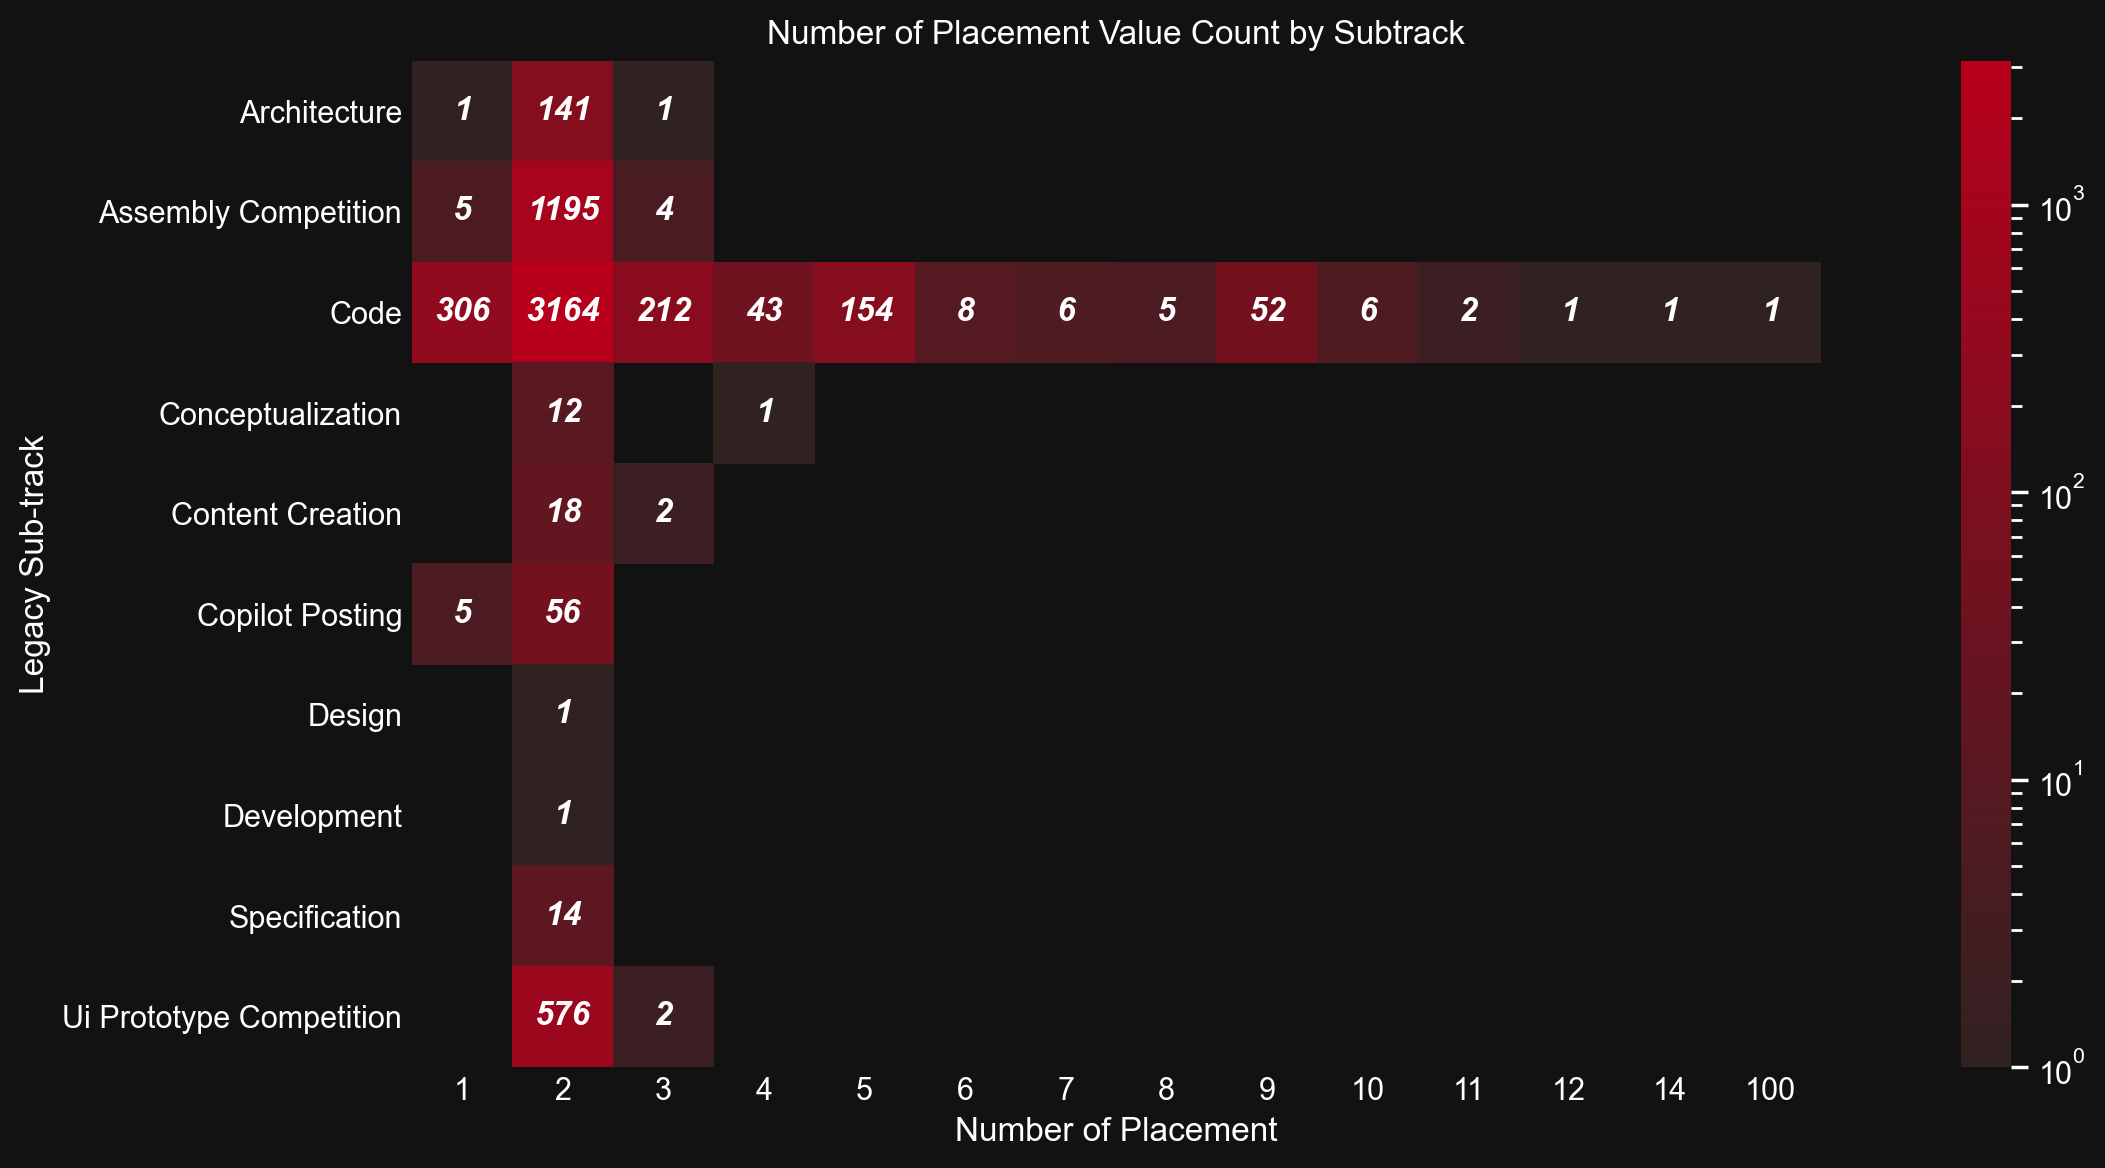

In [29]:
num_of_placement_by_subtrack = prize_set_df.loc[prize_set_df.type == 'Challenge', :].groupby(['legacy_sub_track', 'num_of_placement']).size().unstack(fill_value=0)
num_of_placement_by_subtrack.index = [' '.join(w.capitalize() for w in subtrack.split('_')) for subtrack in num_of_placement_by_subtrack.index]

fig, ax = plt.subplots(figsize=(14.4, 6), dpi=200)

sns.heatmap(
    data=num_of_placement_by_subtrack,
    annot=True,
    fmt='d',
    annot_kws={'ha': 'center', 'va': 'center', 'fontstyle': 'oblique', 'fontweight': 'bold'},
    norm=mcolors.LogNorm(),
    mask=(num_of_placement_by_subtrack == 0),
    cmap=sns.dark_palette('#b8001c' , as_cmap=True),
    square=True,
    ax=ax
)
# ax.xaxis.tick_top()
# ax.xaxis.set_label_position('top')
ax.set_xlabel('Number of Placement')
ax.set_ylabel('Legacy Sub-track')
ax.tick_params(length=0)
ax.set_title('Number of Placement Value Count by Subtrack')

if SAVEFIG:
    fig.savefig(PATH / 'num_of_placement_by_subtrack_heatmap.png', dpi='figure', transparent=TRANSPARENT)

In [30]:
num_of_placement_by_subtrack.sum().sum()

5996

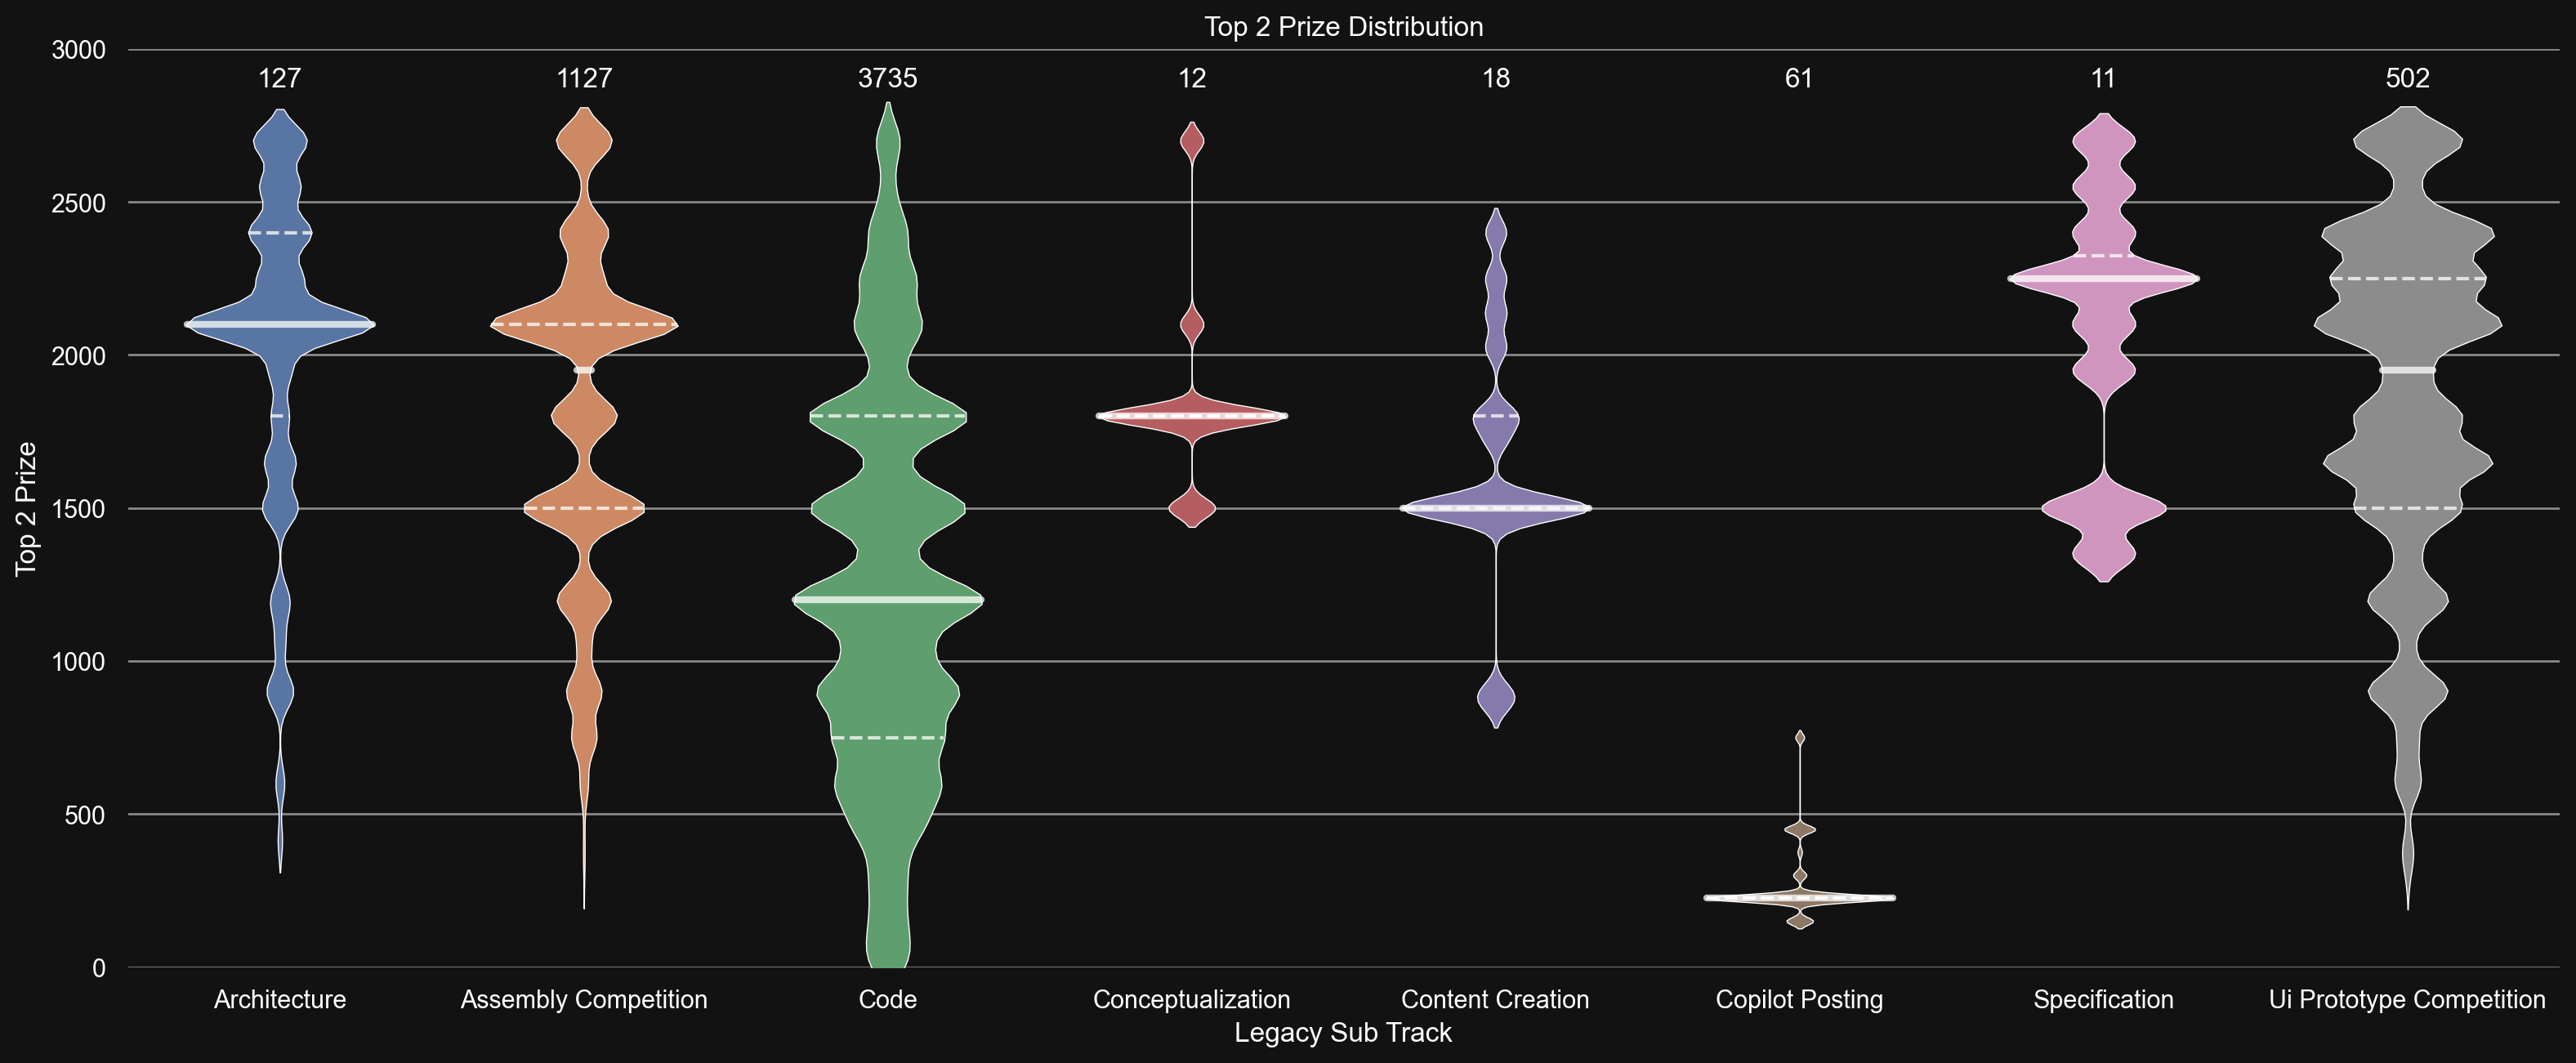

In [31]:
fig, ax = plt.subplots(figsize=(16, 6.67), dpi=200)
completed_development_challenges = prize_set_df.loc[
    (prize_set_df.type == 'Challenge') &
    (prize_set_df.top2_prize <= prz_maj_df.loc['top2_prize', 'Challenge']) &
    (prize_set_df.top2_prize > 0) &
    ~prize_set_df.legacy_sub_track.isin(['DESIGN', 'DEVELOPMENT'])
].reindex(['legacy_sub_track', 'top2_prize'], axis=1)
data_count = completed_development_challenges.groupby('legacy_sub_track').size()

sns.violinplot(
    data=completed_development_challenges,
    x='legacy_sub_track',
    y='top2_prize',
    inner='quartile',
    width=0.618,
    bw=0.1,
    scale='width',
    ax=ax,
)


sns.despine(ax=ax, left=True, bottom=True)
ax.set_ylim(0, 3000)
ax.yaxis.grid(True, alpha=0.5, color='white')
ax.set_title('Top 2 Prize Distribution')
ax.set_xlabel('Legacy Sub Track')
ax.set_ylabel('Top 2 Prize')

for x, tl in enumerate(ax.get_xticklabels()):
    count = data_count[tl.get_text()]
    ax.text(x, 2900, int(count), ha='center', va='center')

xticklabels = [' '.join(w.capitalize() for w in tl.get_text().split('_')) for tl in ax.get_xticklabels()]
ax.set_xticklabels(xticklabels)

# Configure the line color of poly path
for path in ax.collections[:8]:
    path.set_edgecolor('white')
    path.set_linewidth(0.5)
#     path.set_alpha(0.9)
    
# Configure quartile line
for line in ax.lines:
    line.set_linestyle('--')
    line.set_linewidth(1.5)
    line.set_color('white')
    line.set_alpha(0.75)

# Specifically configure 50% quartile
for line in ax.lines[1::3]:
    line.set_linestyle('-')
    line.set_linewidth(3)

if SAVEFIG:
    fig.savefig(PATH / 'prize_distribution_by_sub_track.png', dpi='figure', transparent=TRANSPARENT)

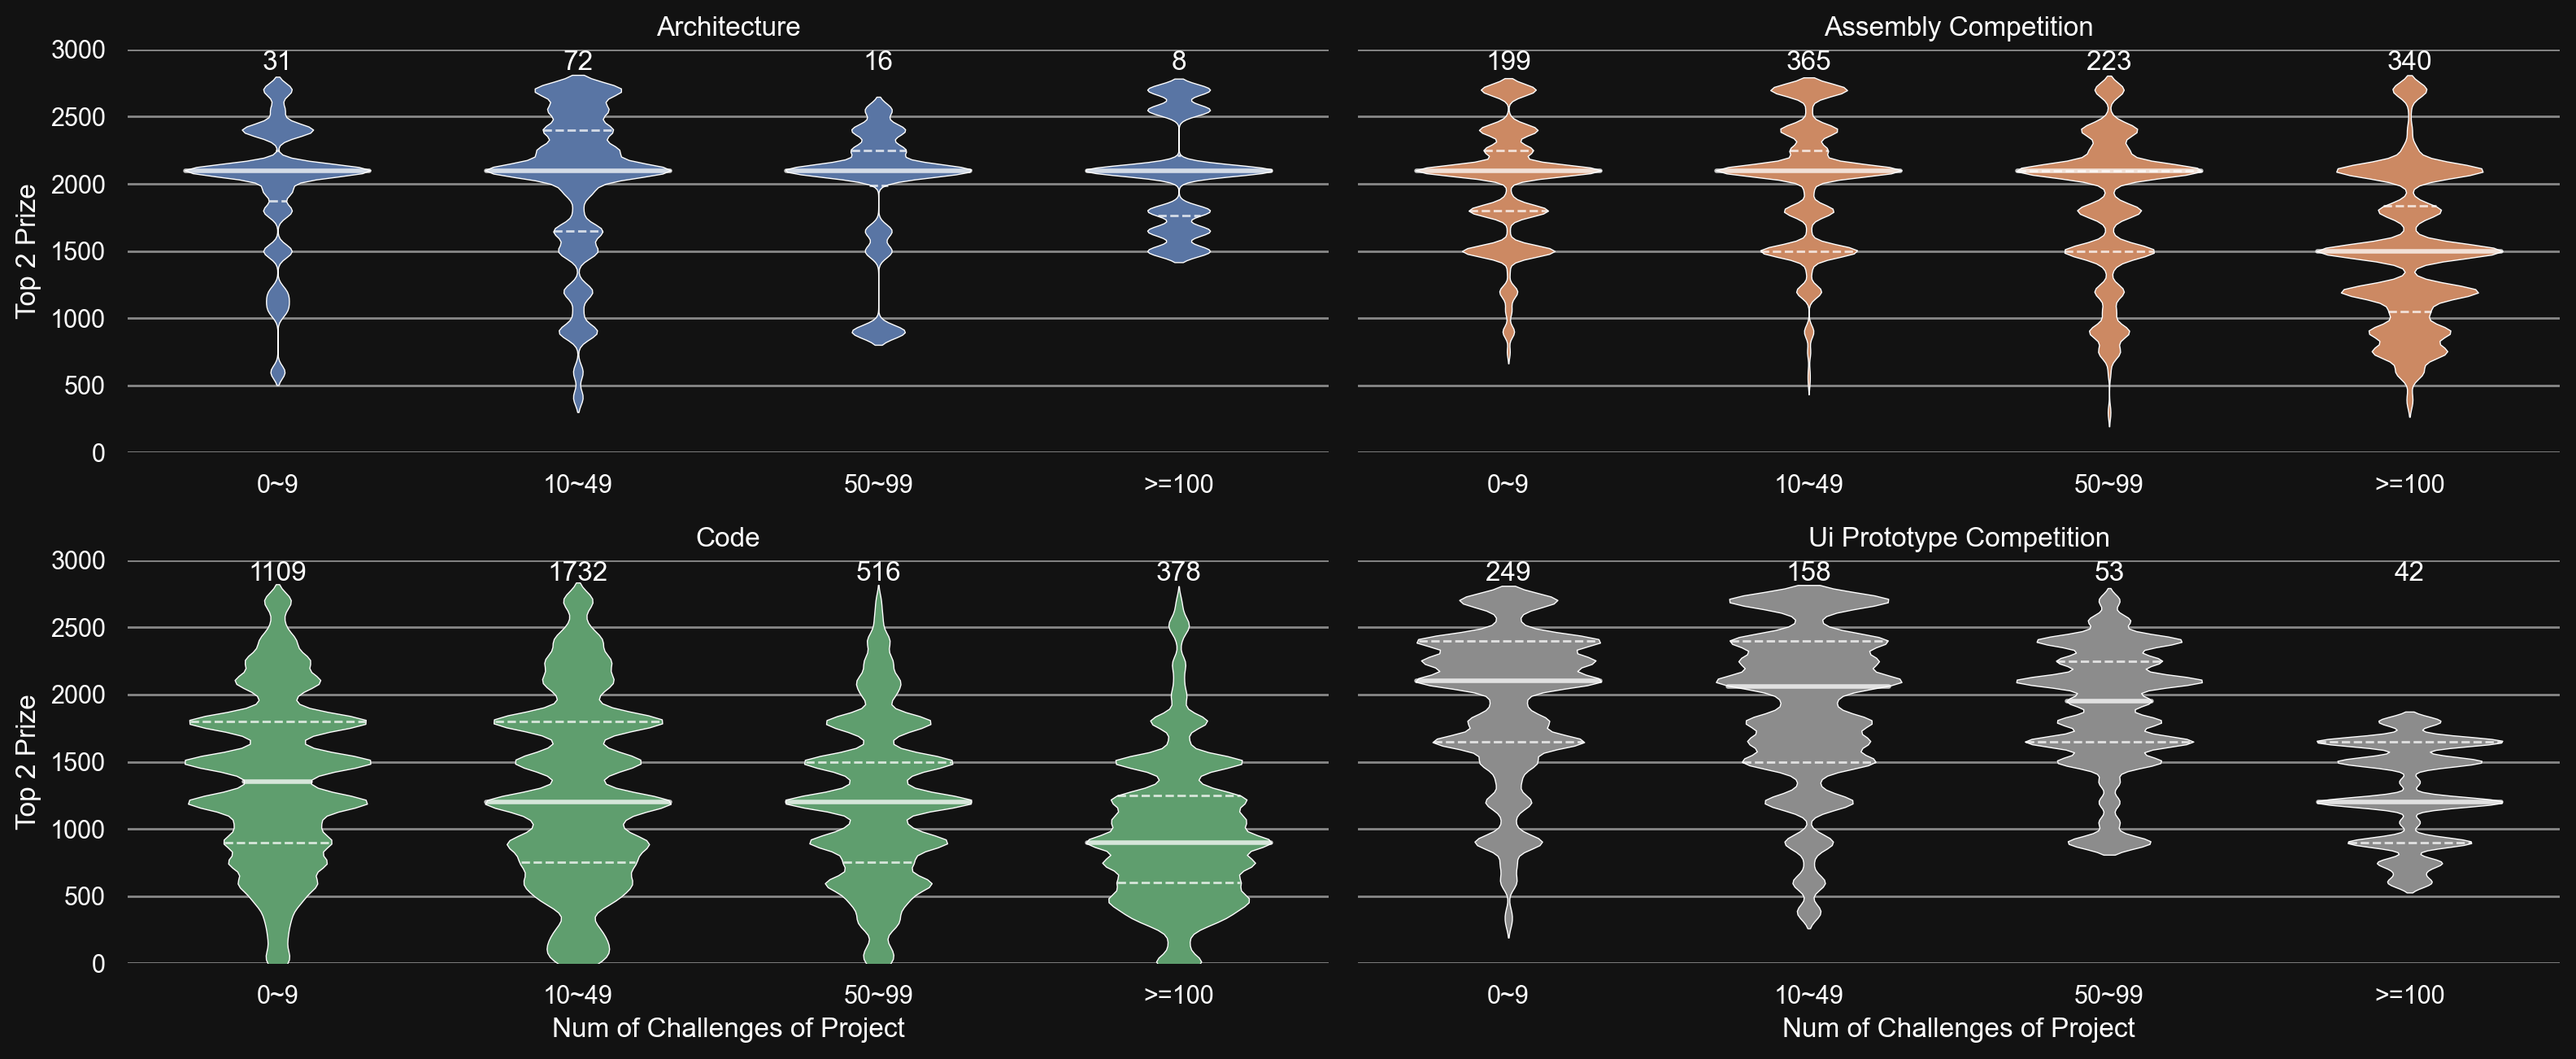

In [32]:
tagged_challenge_df = pd.concat(
    [
        pd.DataFrame({'id': row.challenge_lst, 'tag': row.tag})
        for row in project_tag_df.reset_index().itertuples()
    ], ignore_index=True
).set_index('id')

tagged_comp_dev_cha = completed_development_challenges.join(tagged_challenge_df, how='inner')

specific_sub_track = ['ARCHITECTURE', 'ASSEMBLY_COMPETITION', 'CODE', 'UI_PROTOTYPE_COMPETITION']
specific_st_color = np.array(sns.color_palette(n_colors=8).as_hex())[[0, 1, 2, 7]].tolist()

fig, axes = plt.subplots(2, 2, figsize=(16, 6.67), dpi=200, sharey=True)
for idx, (st, color) in enumerate(zip(specific_sub_track, specific_st_color)):
    ax = axes.flat[idx]
    data = tagged_comp_dev_cha.loc[tagged_comp_dev_cha.legacy_sub_track == st]
    data_count = data.groupby('tag').size()

    sns.violinplot(
        data=data,
        x='tag',
        y='top2_prize',
        order=['0~9', '10~49', '50~99', '>=100'],
        color=color,
        inner='quartile',
        width=0.618,
        bw=0.1,
        scale='width',
        ax=ax,
    )
    
    for x, tl in enumerate(ax.get_xticklabels()):
        count = data_count[tl.get_text()]
        ax.text(x, 2900, int(count), ha='center', va='center')

    sns.despine(ax=ax, left=True, bottom=True)
    ax.set_ylim(0, 3000)
    ax.yaxis.grid(True, color='white', alpha=0.5)
    ax.set_title(' '.join(w.capitalize() for w in st.split('_')))
    ax.set_xlabel('Num of Challenges of Project' if idx >= 2 else '')
    ax.set_ylabel('Top 2 Prize' if idx % 2 == 0 else '')

    # Configure the line color of poly path
    for path in ax.collections[:4]:
        path.set_edgecolor('white')
        path.set_linewidth(0.5)
#         path.set_alpha(0.75)

    # Configure quartile line
    for line in ax.lines:
        line.set_linestyle('--')
        line.set_linewidth(1)
        line.set_color('white')
        line.set_alpha(0.75)

    # Specifically configure 50% quartile
    for line in ax.lines[1::3]:
        line.set_linestyle('-')
        line.set_linewidth(2)
        

if SAVEFIG:
    fig.savefig(PATH / 'prize_distribution_by_sub_track_specific.png', dpi='figure', transparent=TRANSPARENT)

### Text section similarity with TF-IDF

In [33]:
section_similarity = pd.DataFrame.from_records(data=DB.TopcoderMongo.get_project_section_similarity()).set_index(['project_id', 'name'])

In [34]:
section_similarity

similarity  frequency
project_id name                                              
18949      Project Overview               0.500000   1.000000
           Submission Deliverables        0.000000   1.000000
           Localization                   0.666667   0.666667
           Documentation                  0.000000   0.333333
           Competition Task Overview      0.161826   1.000000
...                                            ...        ...
11209      Technology Stack               0.000000   0.666667
           Final Submission Guidelines    0.108596   1.000000
           Important Notes                0.000000   0.666667
24115      Final Submission Guidelines    0.000000   1.000000
           null                           0.000000   1.000000

[9017 rows x 2 columns]

In [35]:
sec_sim_cnt = section_similarity.round(2).groupby(['similarity', 'frequency']).size().sort_index()
sec_sim_cnt = sec_sim_cnt[(sec_sim_cnt.index.get_level_values(0) <= 1) & (sec_sim_cnt.index.get_level_values(1) <=1)]

# Manuanly fill in the missing value and sort index before unstack
for i in np.linspace(0, 1, 101):
    for j in np.linspace(0, 1, 101):
        if (i.round(2), j.round(2)) not in sec_sim_cnt.index:
            sec_sim_cnt[i.round(2), j.round(2)] = 0

sim_freq_pivot_table = sec_sim_cnt.sort_index().unstack().sort_index(ascending=False)

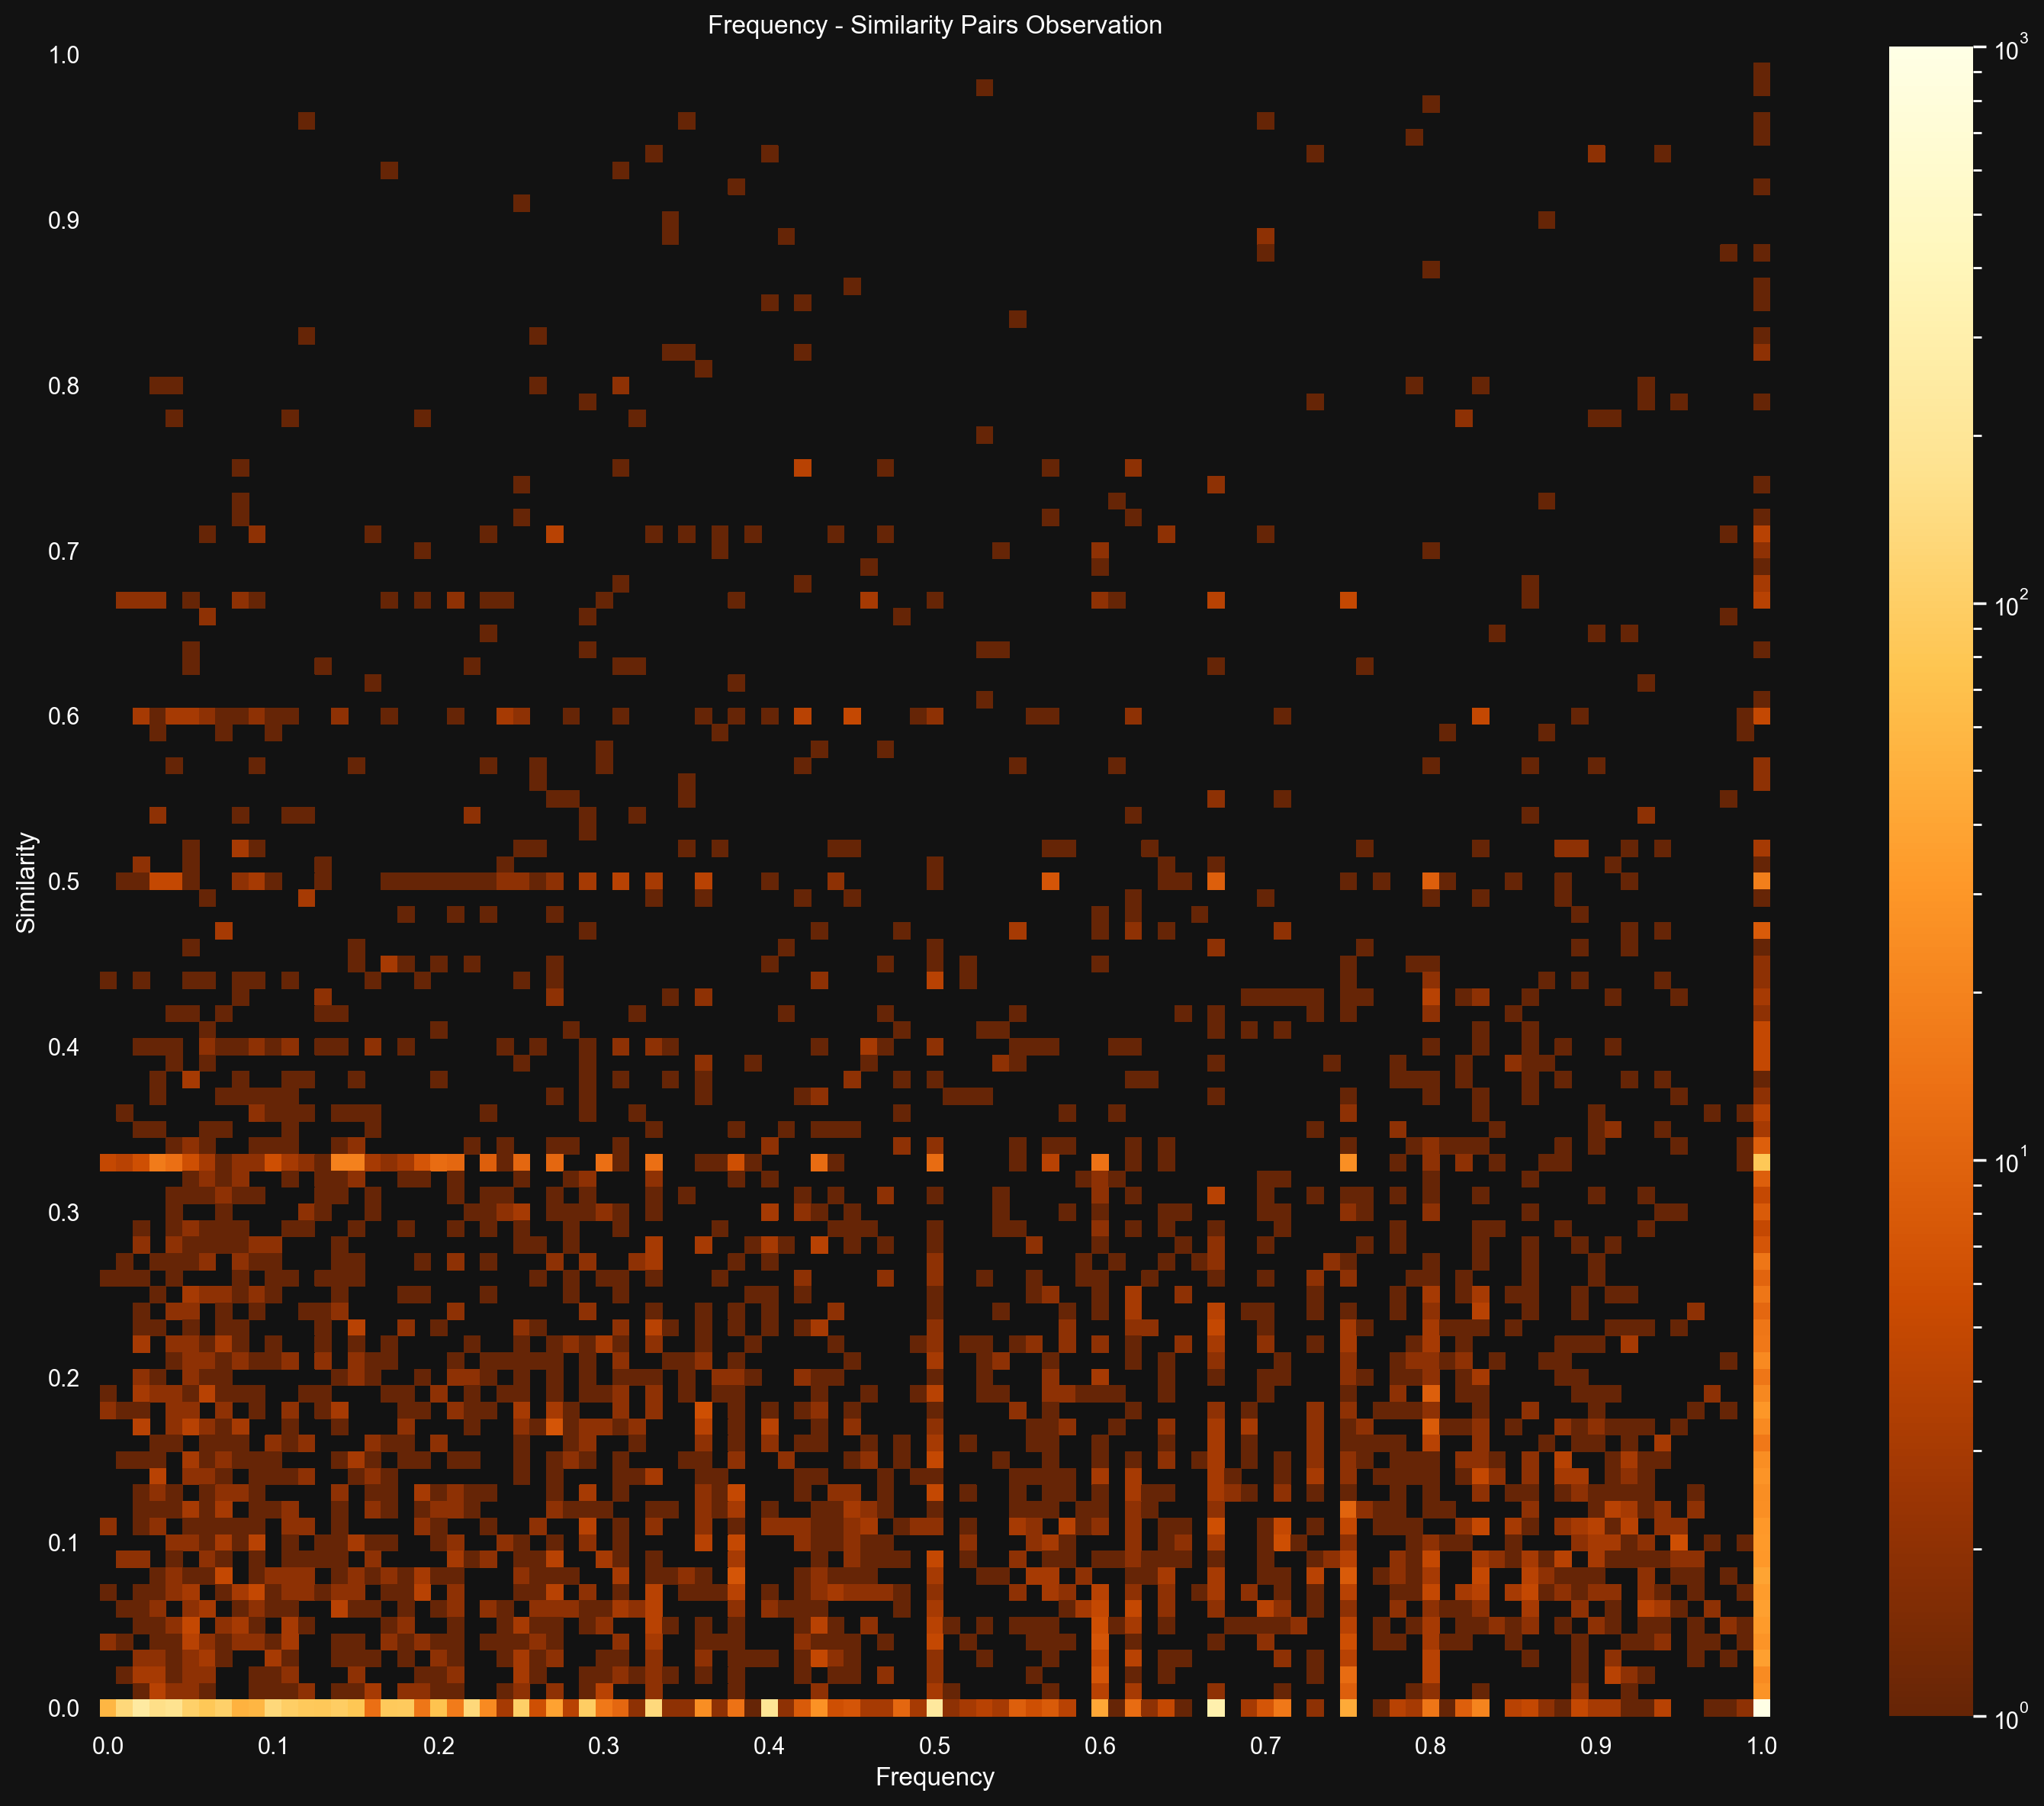

In [36]:
fig, ax = plt.subplots(figsize=(16, 12), dpi=200)

sns.heatmap(
    data=sim_freq_pivot_table,
    norm=mcolors.LogNorm(vmin=10 ** 0, vmax=10 ** 3),
    mask=(sim_freq_pivot_table == 0),
    cmap=sns.color_palette('YlOrBr_r', as_cmap=True),
    square=True,
    ax=ax
)

ax.set_xlabel('Frequency')
ax.set_ylabel('Similarity')
ax.set_title('Frequency - Similarity Pairs Observation')

# Ticks and ticklabels are identical for X and Y axis
xticks = ax.get_xticks()
xticklabels = ax.get_xticklabels()
ax.set_xticks(xticks[::5])
ax.set_xticklabels(xticklabels[::5], rotation=0)

yticks = ax.get_yticks()
yticklabels = ax.get_yticklabels()
ax.set_yticks(yticks[::5])
ax.set_yticklabels(yticklabels[::5], rotation=0)

if SAVEFIG:
    fig.savefig(PATH / 'freq_sim_heatmap.png', dpi='figure', transparent=TRANSPARENT)

In [37]:
sim_freq_pivot_table

frequency,0.00,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,...,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99,1.00
similarity,,,,,,,,,,,,,,,,,,,,,
1.00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0.99,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
0.98,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
0.97,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0.96,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
0.95,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
0.94,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
0.93,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0.92,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
